# Experiment 2: High Resolution Spectroscopy, Nonlinear Spectrum
## Experimentalpraktikum A, Universität Innsbruck, WS 2025/26
### Zarah Aigner 

In [2]:
# importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import configparser
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import pandas as pd
from scipy.constants import e, c, h, nano
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO
from scipy.optimize import curve_fit
from scipy.special import wofz
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress, t as tdist

font1 = {'family':'sans-serif','color':'black','size':12}
font2 = {'family':'sans-serif','color':'black','size':20}

plt.rcParams['text.usetex'] = True #LaTeX

Index(['time', 'CH1', 'CH2', 'CH3'], dtype='object')
          time   CH1     CH2  CH3
0     0.000954  0.00  0.0033  716
1     0.000955  0.00  0.0035  716
2     0.000957  0.00  0.0035  716
3     0.000958  0.00  0.0035  716
4     0.000960 -0.08  0.0033  716
...        ...   ...     ...  ...
1995  0.004146  0.00 -0.0021  932
1996  0.004147  0.00 -0.0019  932
1997  0.004149  0.00 -0.0019  932
1998  0.004150  0.00 -0.0021  932
1999  0.004152  0.00 -0.0021  932

[2000 rows x 4 columns]


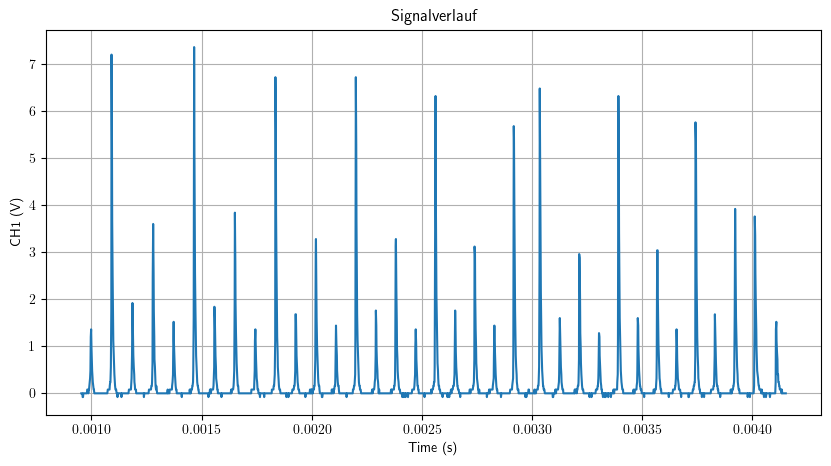

In [3]:
pathname = "/Users/zarahaigner/Documents/Physik_Master_1/FP_2/High_resolution/Data_Nonlinear-final.csv" #insert path name, if code is reused please modify
data = pd.read_csv(pathname, header=None, names=["time", "CH1", "CH2", "CH3"])
print(data.columns)
time = data["time"]
ch1 = data["CH1"]
ch2 = data["CH2"]
ch3 = data["CH3"]

print(data)

plt.figure(figsize=(10,5))
plt.plot(time, ch1)
plt.xlabel("Time (s)")
#plt.xlim(0.0010,0.004)
plt.ylabel("CH1 (V)")
#plt.xlim(0.00175,0.00225)
plt.title("Signalverlauf")
plt.grid(True)
plt.show()

0.0003570000000000001


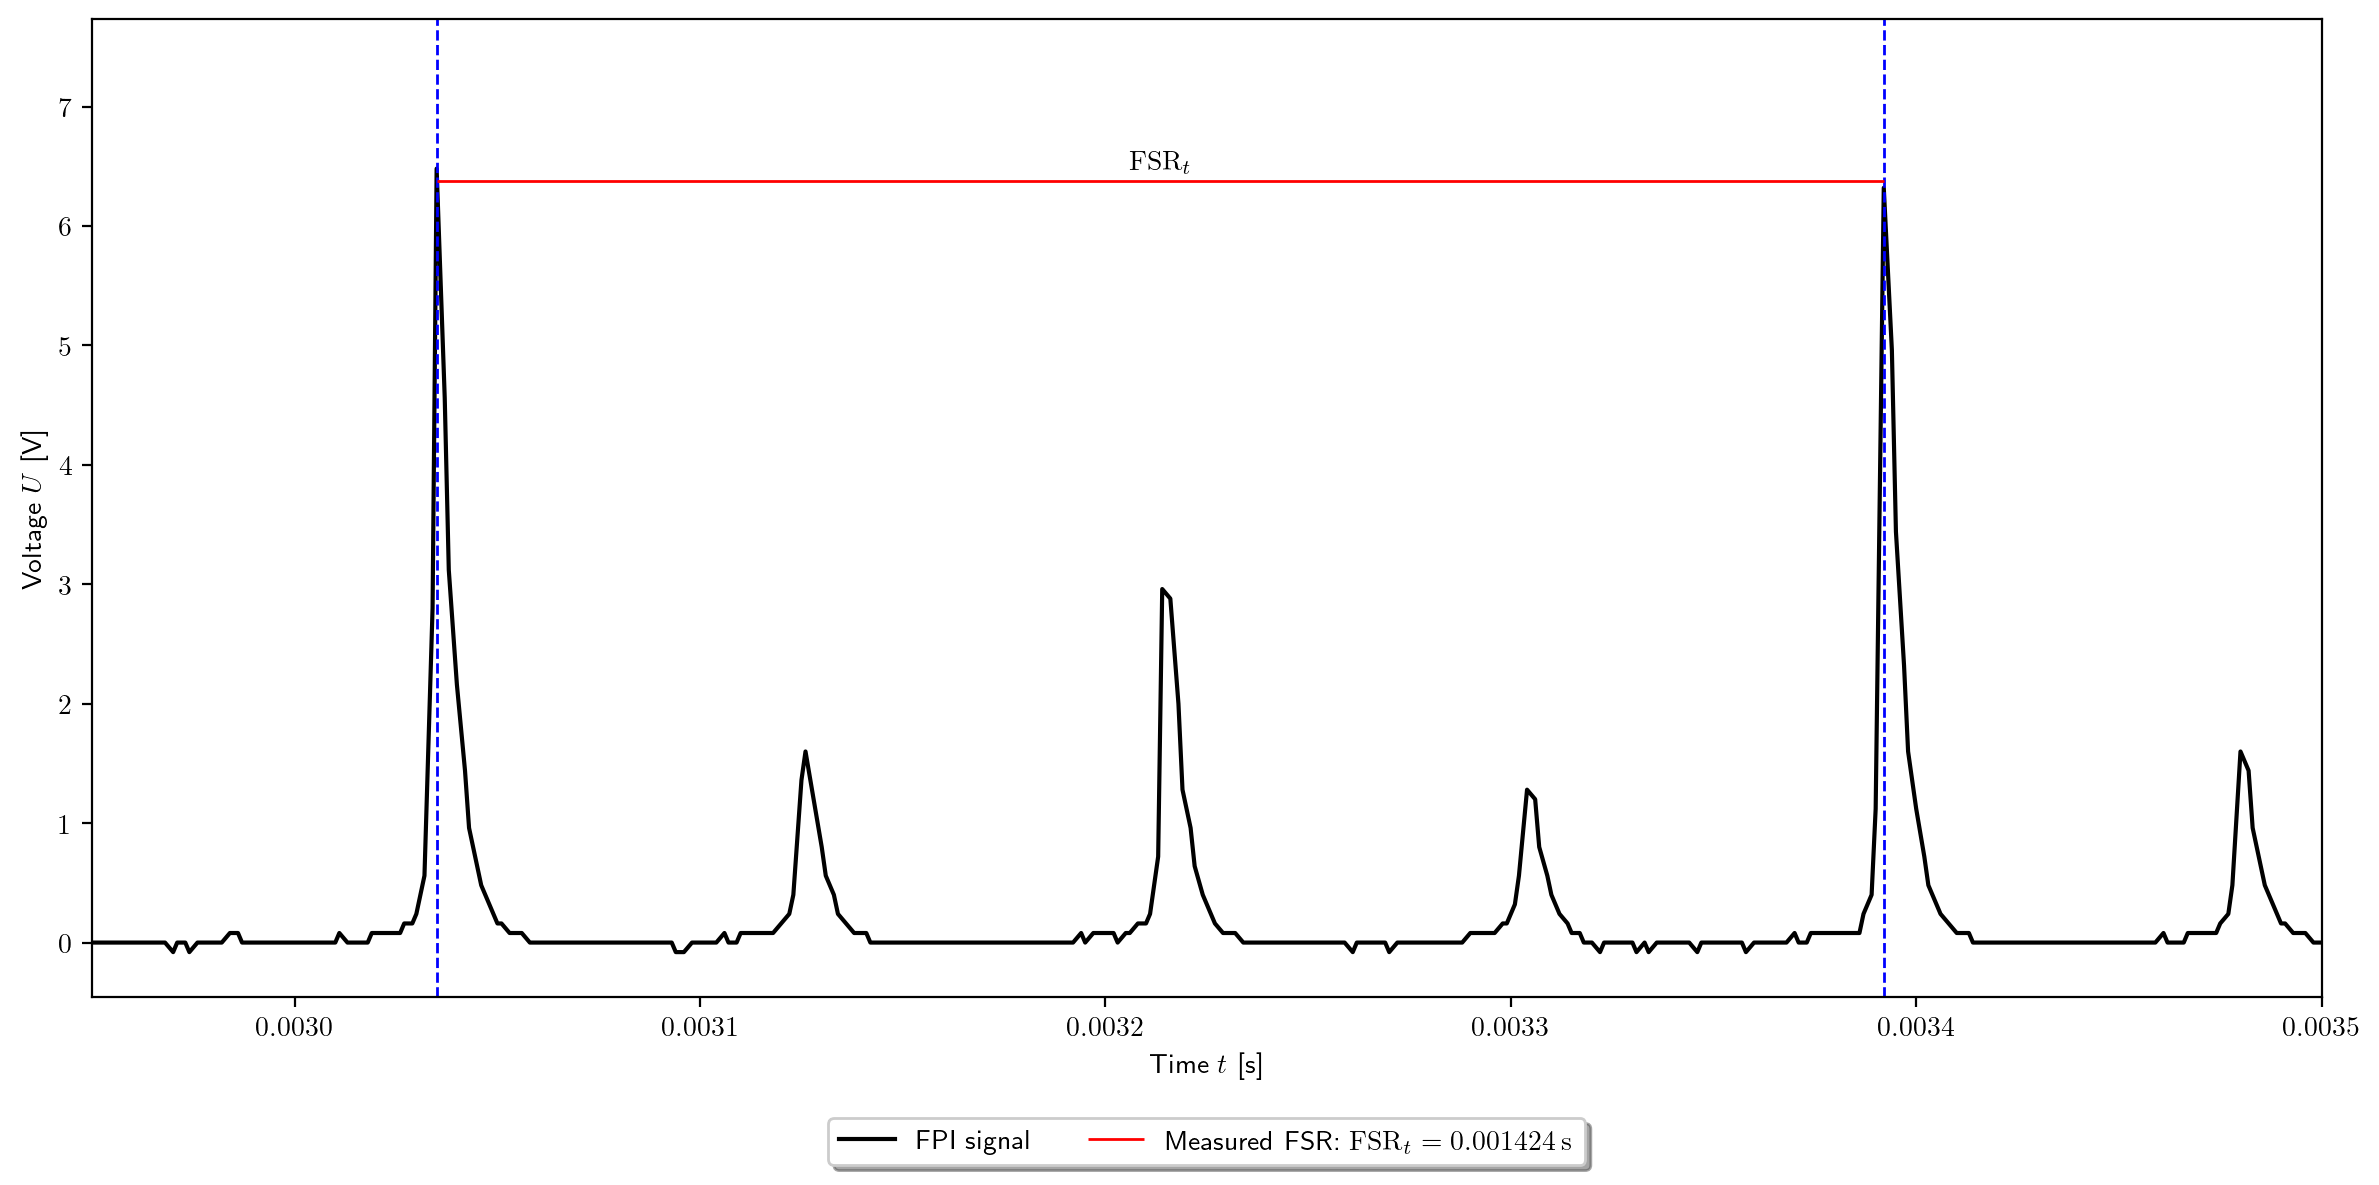

0.0003570000000000001


In [4]:
# loading the data -> converting to numpy arrays
t   = np.array(time)
sig = np.array(ch1)

# defining the masks to find the FSR of the data
mask1 = (t > 0.003) & (t < 0.0033) #(t > 0.004) & (t < 0.0045)#(t > 0.0025) & (t < 0.0026)
t1_candidates = t[mask1]
s1_candidates = sig[mask1]

idx1_local = np.argmax(s1_candidates)
t1 = t1_candidates[idx1_local]
A1 = s1_candidates[idx1_local]

mask2 = (t > 0.0033) & (t < 0.0035)#(t > 0.0045) & (t < 0.0050)
t2_candidates = t[mask2]
s2_candidates = sig[mask2]

idx2_local = np.argmax(s2_candidates)
t2 = t2_candidates[idx2_local]
A2 = s2_candidates[idx2_local]

# Computing FSR
FSR_time = t2 - t1#0.0015
FSR_freq = 1.50e9   # 1.50 GHz -> cpmputed with values from the script
print(FSR_time)

alpha = FSR_freq / FSR_time

# plot to ensure the FSR determination works
plt.figure(figsize=(12,6), dpi=200)
plt.plot(t, sig, label=r"FPI signal", color="black")
plt.axvline(t1, color="blue", linestyle="--", linewidth=1)
plt.axvline(t2, color="blue", linestyle="--", linewidth=1)
y_line = max(A1, A2) - 0.1    # etwas oberhalb der Peak-Höhen

plt.hlines(
    y=y_line, 
    xmin=t1, xmax=t2, 
    color="red", 
    linestyle="-", 
    linewidth=1,
    label=r"Measured FSR: $\mathrm{FSR}_t=0.001424\:\mathrm{s}$"
)

plt.text((t1+t2)/2, y_line + 0.1, r"$\mathrm{FSR}_t$", ha="center")

plt.xlabel(r"Time $t$ [s]")
plt.ylabel(r"Voltage $U$ [V]")
plt.xlim(0.00295, 0.0035)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.11), fancybox=True, shadow=True, ncol=2)
plt.tight_layout()
plt.savefig("A2_determination_FSR_Nonlinear.pdf")
plt.show()
print(FSR_time)

In [5]:
print("FSR (in Zeit) =", FSR_time, "s pro Resonanz")

# frequency FSR
FSR_freq = 1.50e9  # 1.50 GHz

# Sweepvelocity
alpha = FSR_freq / FSR_time
print("\nSweep-Geschwindigkeit α =", alpha, "Hz/s")



FSR (in Zeit) = 0.0003570000000000001 s pro Resonanz

Sweep-Geschwindigkeit α = 4201680672268.9062 Hz/s


t0 = 0.0009536


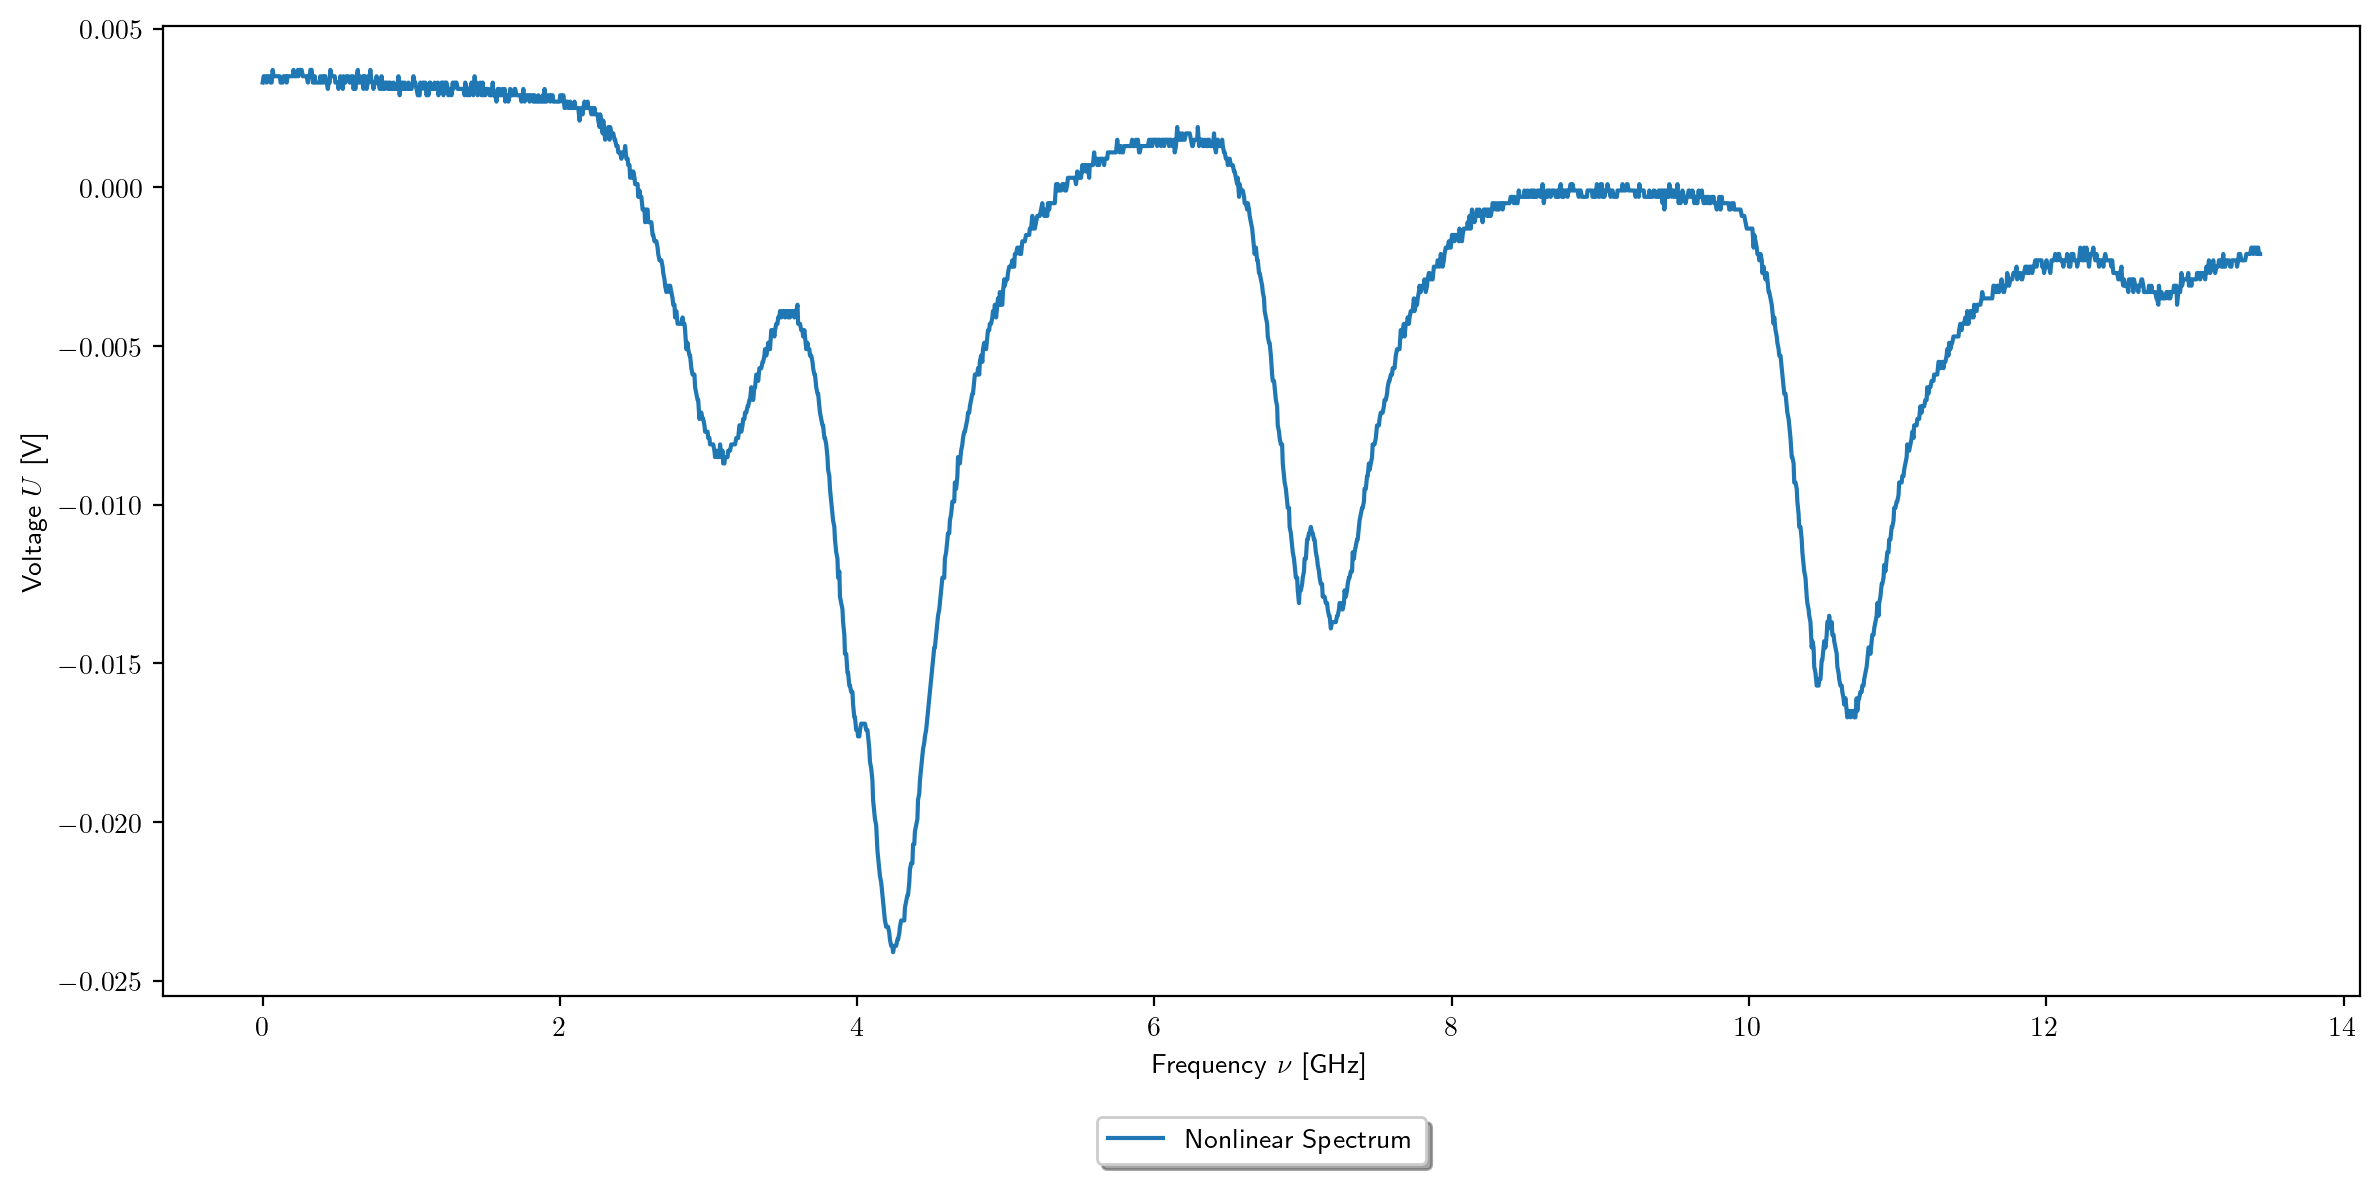

Background-Fit: CH2_bg = -0.0000 * CH3 + 0.0185


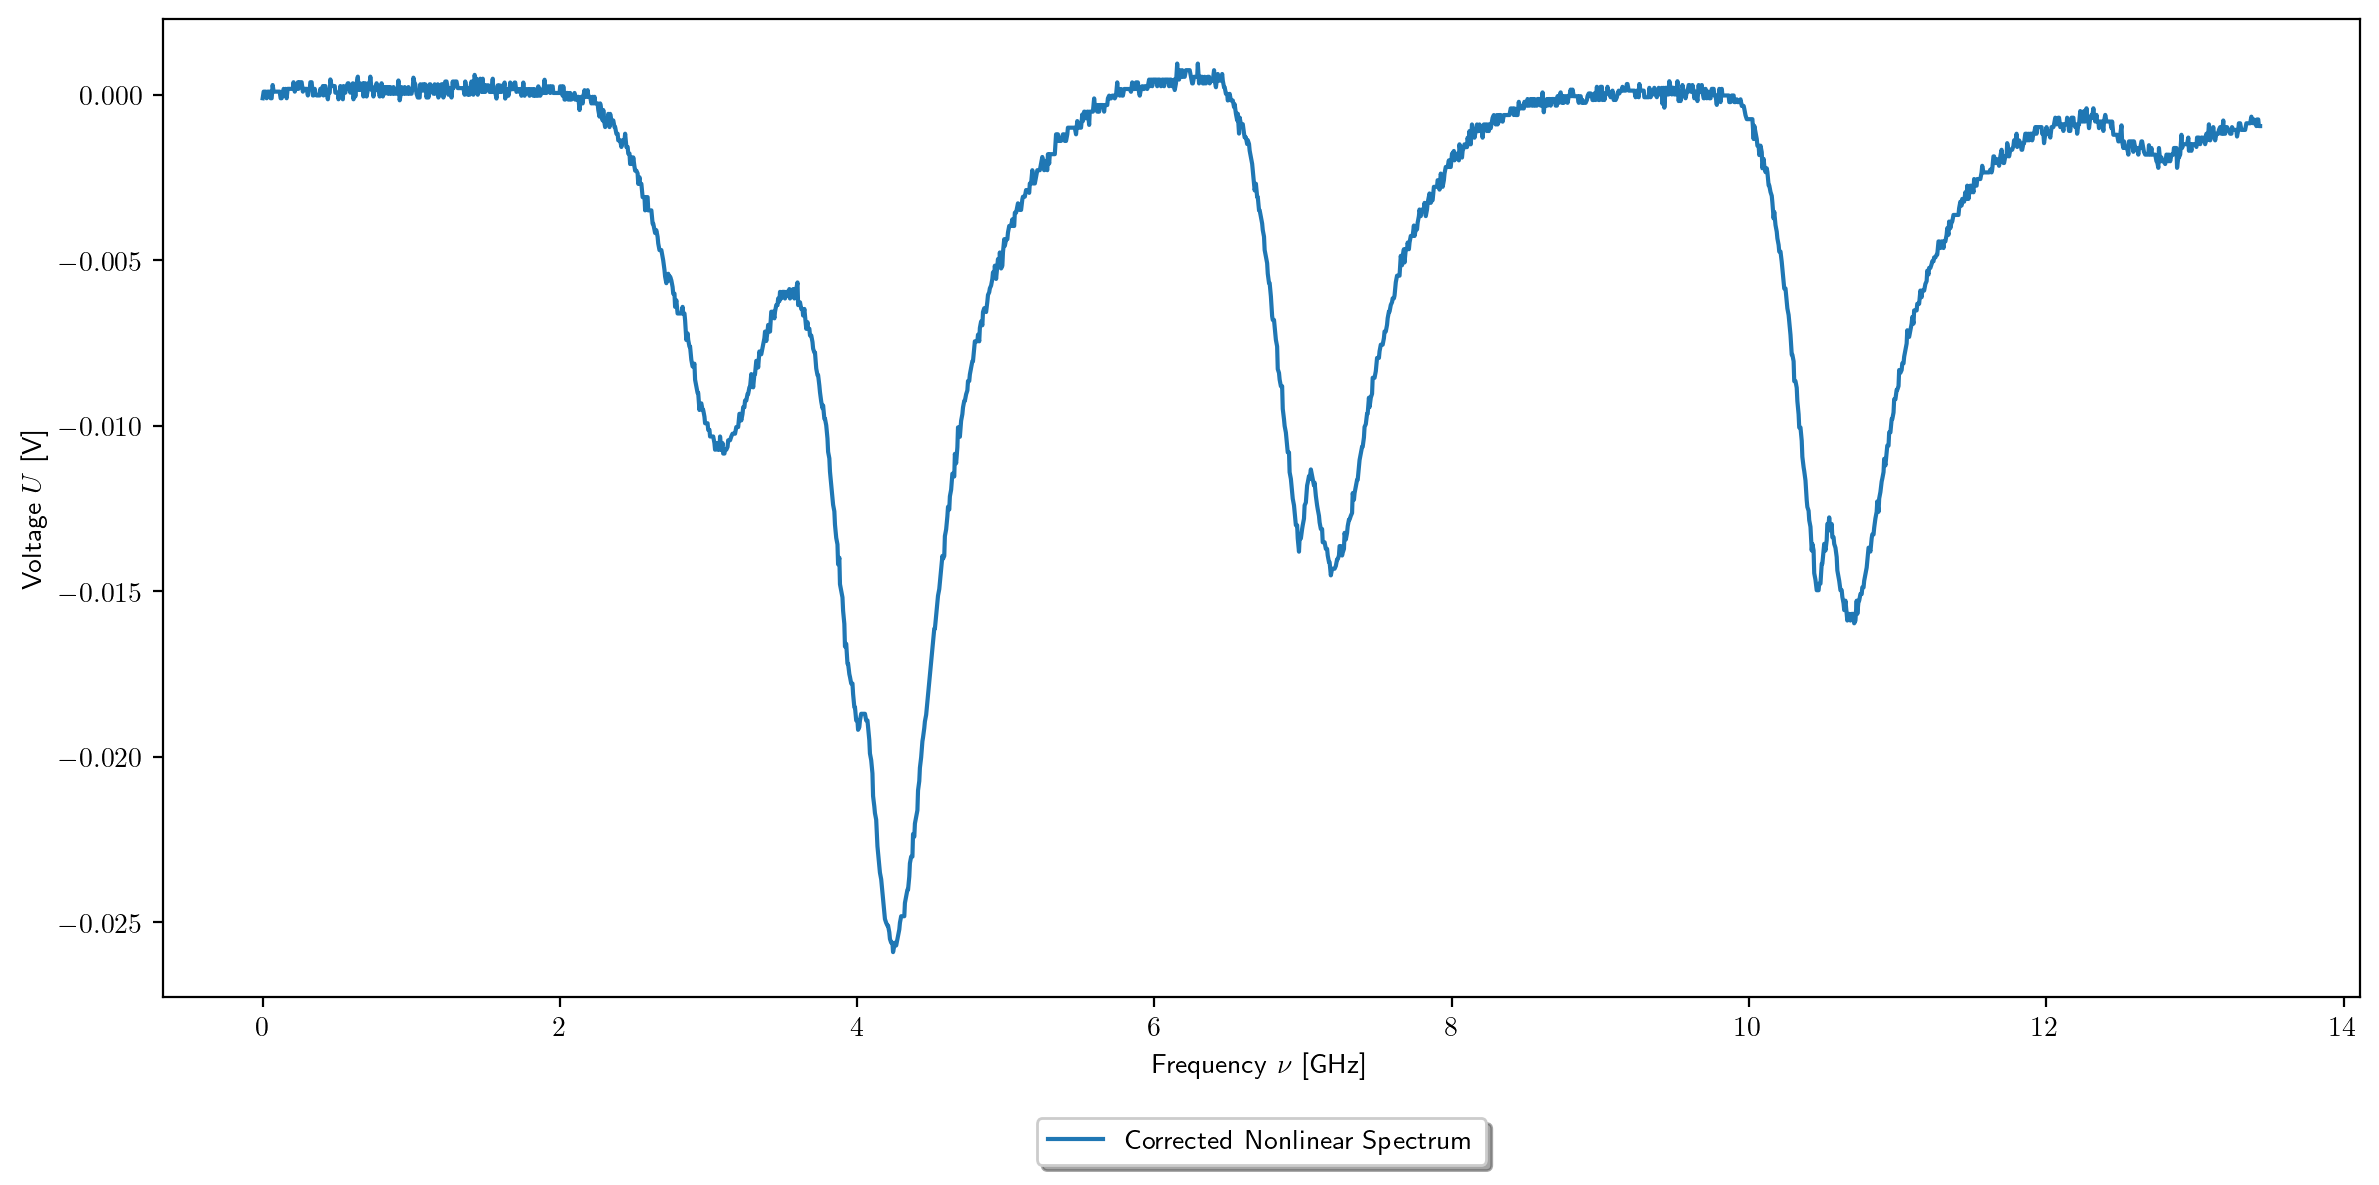

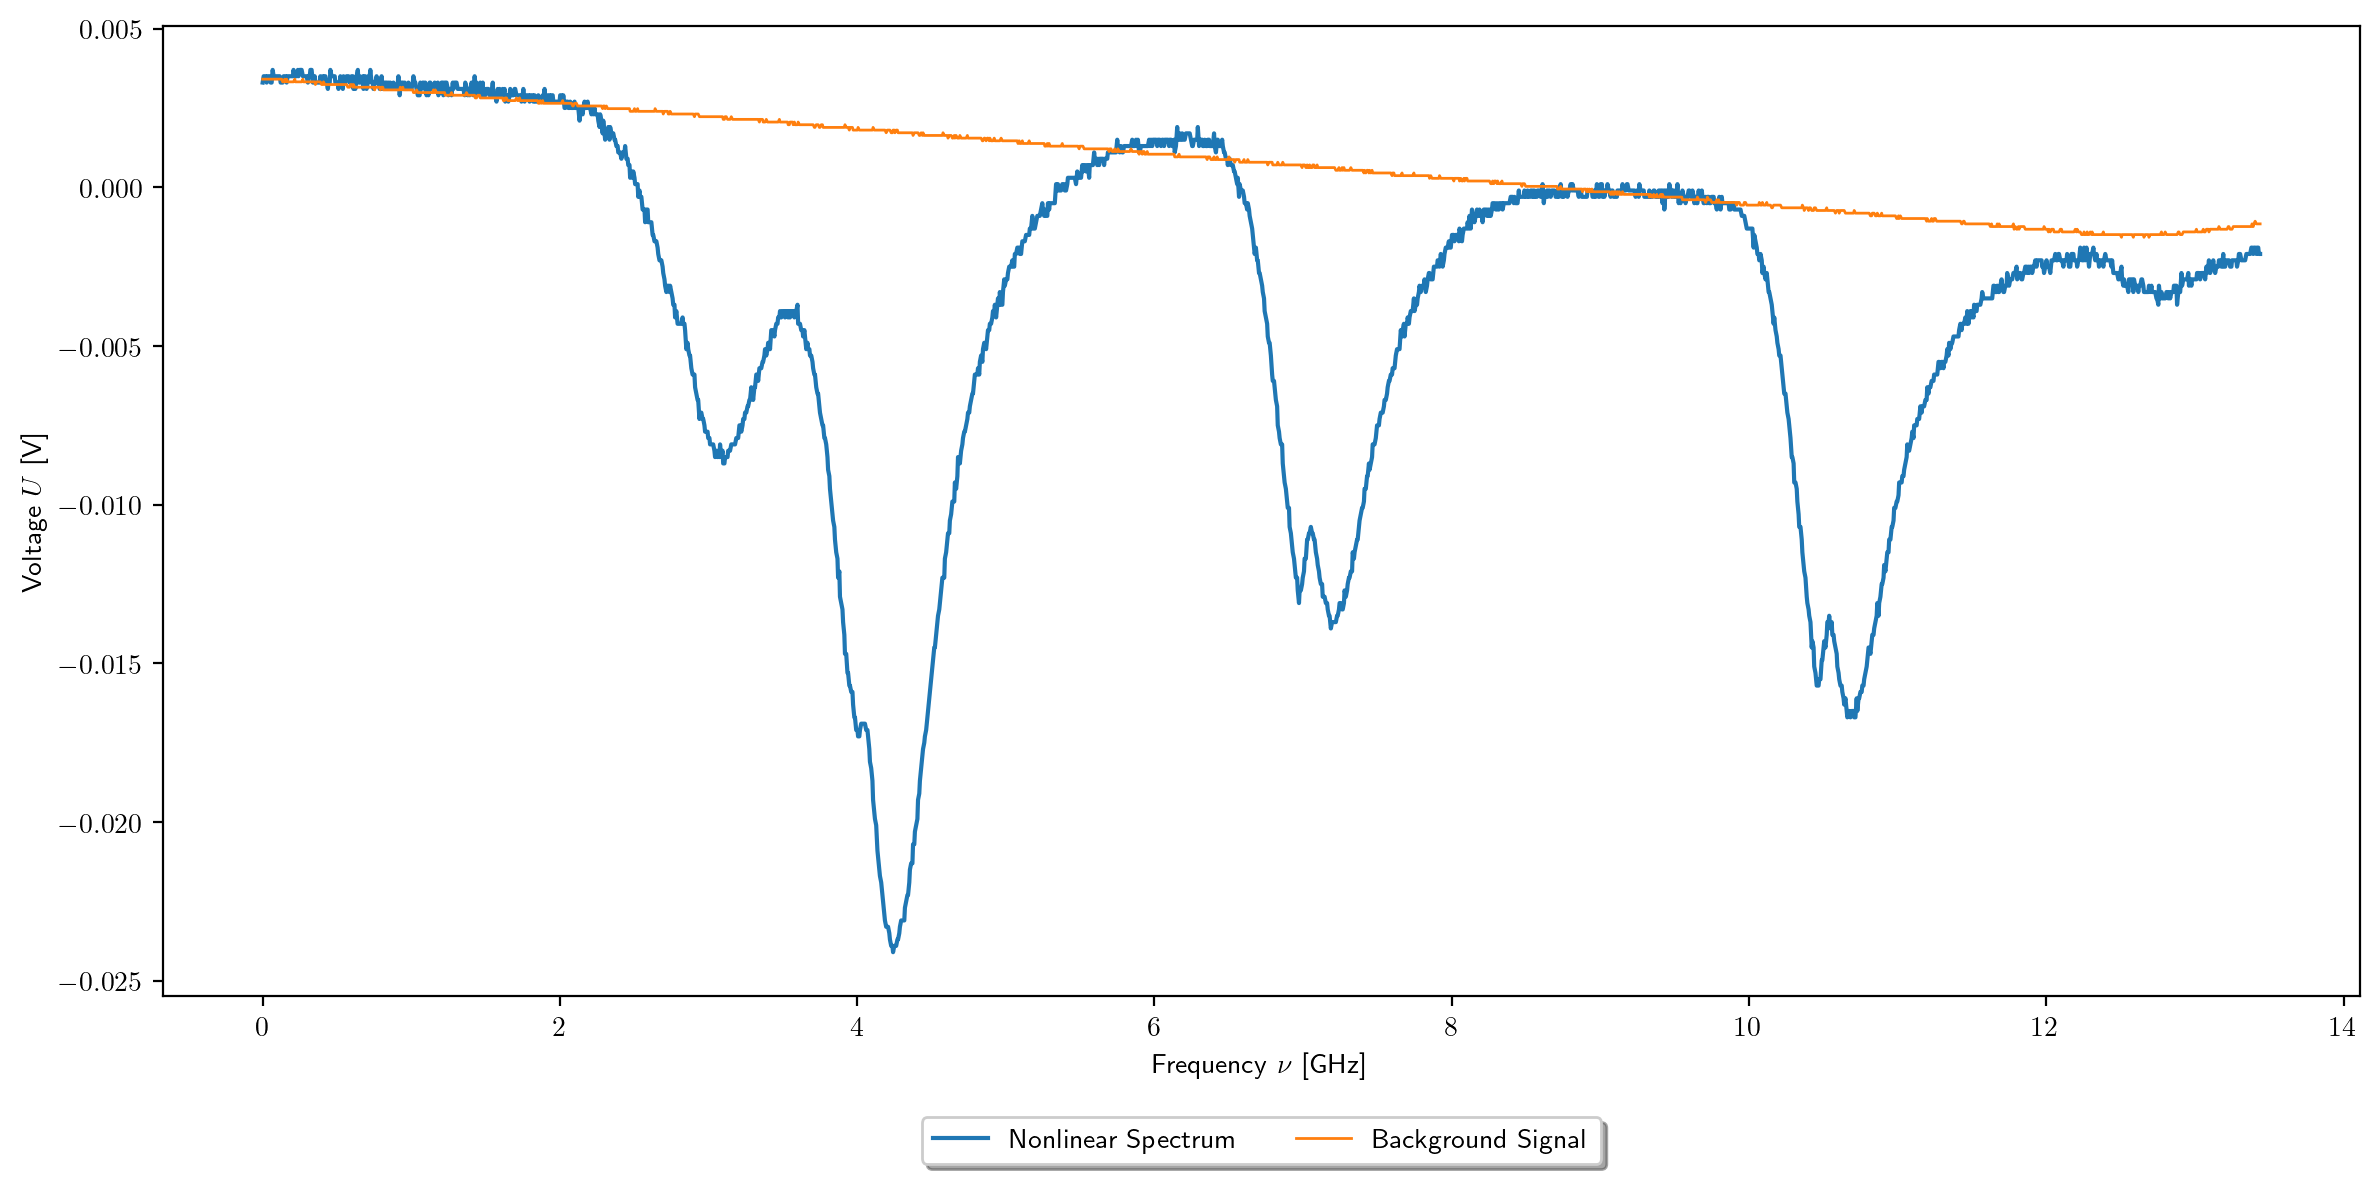

In [6]:
# scaliing
t0 = t[0]
print("t0 =", t0)

freq = alpha * (time - t0)
plt.figure(figsize=(12,6), dpi=200)
plt.plot(freq/1e9, ch2, label=r"Nonlinear Spectrum")
plt.xlabel(r"Frequency $\nu$ [GHz]")
plt.ylabel(r"Voltage $U$ [V]")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.11), fancybox=True, shadow=True, ncol=2)
plt.tight_layout()
plt.grid(False)
plt.savefig("A2_signal_raw_Nonlinear.pdf")
plt.show()

# changing to GHz 
freq_GHz = freq/1e9

# determination of background -> just fiiting the linear parts about the upper 30%
mask_bg = ch2 > np.percentile(ch2, 70)   

# Fit: CH2_bg = a*CH3 + b -> using signal from ch3 for background
coeffs = np.polyfit(ch3[mask_bg], ch2[mask_bg], deg=1)
a, b = coeffs

# printing the fit function 
print(f"Background-Fit: CH2_bg = {a:.4f} * CH3 + {b:.4f}")

# computing the background with the fit function
background = a * ch3 + b

# subtraction of ch2 and background -> real ch2 signal
ch2_corr = ch2 - background

# plotting the subtraction of ch2 and background
plt.figure(figsize=(12,6), dpi=200)
plt.plot(freq_GHz, ch2_corr, label=r"Corrected Nonlinear Spectrum")
plt.xlabel(r"Frequency $\nu$ [GHz]")
plt.ylabel(r"Voltage $U$ [V]")
#plt.title("Rubidium absorption (CH3-based background corrected)")
plt.grid(False)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.11), fancybox=True, shadow=True, ncol=2)
plt.tight_layout()
#plt.xlim(2,3.5)
plt.savefig("A2_signal_Nonlinear.pdf")
plt.show()

# plotting the background signal to ensure correct working
plt.figure(figsize=(12,6), dpi=200)
plt.plot(freq_GHz, ch2, label=r"Nonlinear Spectrum")
plt.plot(freq_GHz, background, label=r"Background Signal", linewidth=1)
plt.xlabel(r"Frequency $\nu$ [GHz]")
plt.ylabel(r"Voltage $U$ [V]")
#plt.title("Background fit using CH3 ramp")
plt.grid(False)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.11), fancybox=True, shadow=True, ncol=2)
plt.tight_layout()
plt.savefig("A2_signal_background_Nonlinear.pdf")
plt.show()

## Beschriftetes Spektrum

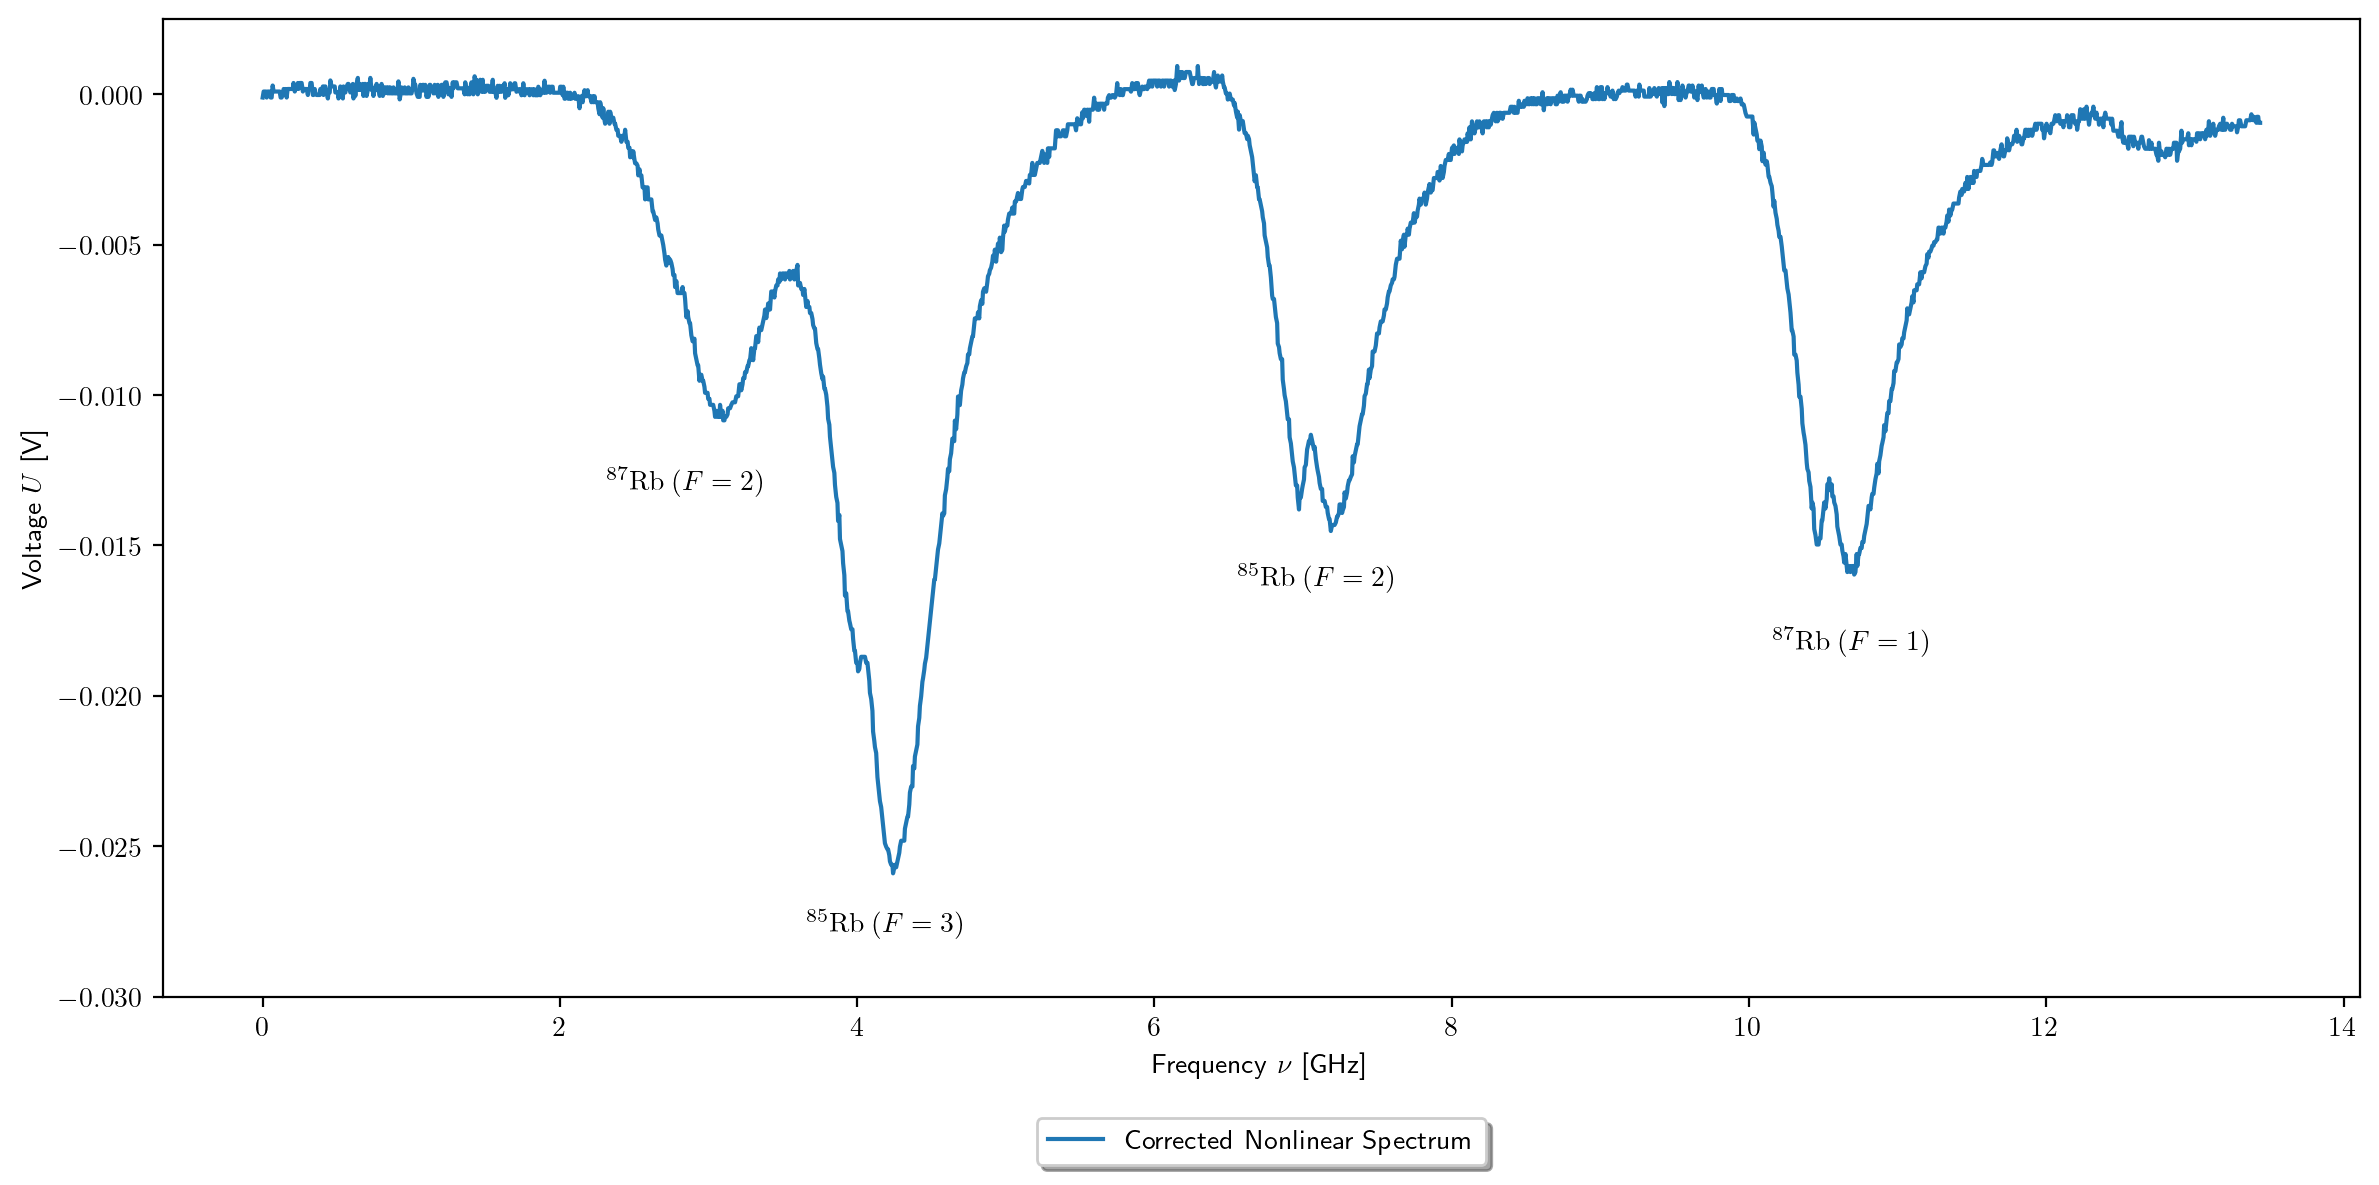

In [7]:
# plotting the subtraction of ch2 and background
plt.figure(figsize=(12,6), dpi=200)
plt.plot(freq_GHz, ch2_corr, label=r"Corrected Nonlinear Spectrum")

# Positionen der Minima:
x1, x2, x3, x4 = 2.85, 4.2, 7.1, 10.7

# y-Werte interpolieren:
y1 = np.interp(x1, freq_GHz, ch2_corr)
y2 = np.interp(x2, freq_GHz, ch2_corr)
y3 = np.interp(x3, freq_GHz, ch2_corr)
y4 = np.interp(x4, freq_GHz, ch2_corr)

# Texte unterhalb der Minima platzieren (va='top'):
plt.text(x1, y1 - 0.005, r"$^{87}\mathrm{Rb}\:(F=2)$", ha="center", va="top")
plt.text(x2, y2 - 0.002, r"$^{85}\mathrm{Rb}\:(F=3)$", ha="center", va="top")
plt.text(x3, y3 - 0.003, r"$^{85}\mathrm{Rb}\:(F=2)$", ha="center", va="top")
plt.text(x4, y4 - 0.002, r"$^{87}\mathrm{Rb}\:(F=1)$", ha="center", va="top")


plt.xlabel(r"Frequency $\nu$ [GHz]")
plt.ylabel(r"Voltage $U$ [V]")
#plt.title("Rubidium absorption (CH3-based background corrected)")
plt.grid(False)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.11), fancybox=True, shadow=True, ncol=2)
plt.tight_layout()
#plt.xlim(2,3.5)
plt.ylim(-0.030,0.0025)
plt.savefig("A2_signal_beschriftet_Nonlinear.pdf")
plt.show()

## Also determine the Groundstate FWHMS and distances betweeen, before investigating the excitation states

In [36]:
"""
Gaussian Fit Function----------------------------------------------------------------------------------------------
"""
def gauss(x, A, mu, sigma, C):
    return C + A * np.exp(-(x - mu)**2 / (2 * sigma**2))


# determining the intervals -> to compute 4 separate Gauß fits
intervals = [
    (2, 3.5),
    (3.6, 5),
    (6, 8),
    (10, 11.5)
]


peak_centers = []
fit_curves = []  
fit_params = []
fit_errors = []   # NEW: store parameter errors

# fitting
for fmin, fmax in intervals:

    mask = (freq_GHz >= fmin) & (freq_GHz <= fmax)
    x = np.array(freq_GHz[mask])
    y = np.array(ch2_corr[mask])

    # starting values
    peaks, _ = find_peaks(-y)
    if len(peaks) == 0:
        print("Kein Peak gefunden in", fmin, fmax)
        continue

    deepest = peaks[np.argmin(y[peaks])]
    mu0 = x[deepest]
    A0 = np.min(y) - np.max(y)
    sigma0 = 0.3
    C0 = np.max(y)

    # fitting
    p0 = [A0, mu0, sigma0, C0]
    popt, pcov = curve_fit(gauss, x, y, p0=p0)

    A, mu, sigma, C = popt

    # --- NEW: parameter errors from covariance ---
    A_err, mu_err, sigma_err, C_err = np.sqrt(np.diag(pcov))

    # FWHM + error (propagation)
    FWHM = 2 * np.sqrt(2*np.log(2)) * sigma
    FWHM_err = 2 * np.sqrt(2*np.log(2)) * sigma_err

    peak_centers.append(mu)
    fit_params.append((A, mu, sigma, C, FWHM))
    fit_errors.append((A_err, mu_err, sigma_err, C_err, FWHM_err))

    # storing the fit curves
    xfit = np.linspace(fmin, fmax, 400)
    yfit = gauss(xfit, *popt)
    fit_curves.append((xfit, yfit))


# producing a plot
plt.figure(figsize=(12,6), dpi=200)
plt.plot(freq_GHz, ch2_corr, label=r"Corrected Nonlinear Spectrum", color="black", linewidth=0.8)

# Positionen der Minima:
x1, x2, x3, x4 = 2.85, 4.2, 7.1, 10.7

# y-Werte interpolieren:
y1 = np.interp(x1, freq_GHz, ch2_corr)
y2 = np.interp(x2, freq_GHz, ch2_corr)
y3 = np.interp(x3, freq_GHz, ch2_corr)
y4 = np.interp(x4, freq_GHz, ch2_corr)

# Texte unterhalb der Minima platzieren (va='top'):
plt.text(x1, y1 - 0.005, r"$^{87}\mathrm{Rb}\:(F=2)$", ha="center", va="top")
plt.text(x2, y2 - 0.002, r"$^{85}\mathrm{Rb}\:(F=3)$", ha="center", va="top")
plt.text(x3, y3 - 0.003, r"$^{85}\mathrm{Rb}\:(F=2)$", ha="center", va="top")
plt.text(x4, y4 - 0.002, r"$^{87}\mathrm{Rb}\:(F=1)$", ha="center", va="top")


colors = ["red", "blue", "green", "orange"]

for i, ((xfit, yfit), col) in enumerate(zip(fit_curves, colors), start=1):

    mu    = fit_params[i-1][1]
    muerr = fit_errors[i-1][1]
    FWHM  = fit_params[i-1][4]
    FWHM_err = fit_errors[i-1][4]

    # Gaussian curve with parameter labels including errors
    plt.plot(
        xfit, yfit, color=col, linewidth=0.8,
        label=fr"Fit {i}: $\mu_{i}$={mu:.3f}$\pm${muerr:.3f} GHz,  "
              fr"FWHM$_{i}$={FWHM:.3f}$\pm${FWHM_err:.3f} GHz"
    )

plt.xlabel(r"Frequency $\nu$ [GHz]")
plt.ylabel(r"Voltage $U$ [V]")
plt.xlim(0,18)
plt.ylim(-0.030,0.0025)
plt.grid(False)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.11),
           fancybox=True, shadow=True, ncol=2)
plt.tight_layout()
plt.savefig("A2_nonlinear_spectrum_groundstates_Nonlinear.pdf")
plt.close()

print("\n--- Gaussian Fit Parameters (with errors) ---\n")

for i, ((A, mu, sigma, C, FWHM), (A_err, mu_err, sigma_err, C_err, FWHM_err)) in \
        enumerate(zip(fit_params, fit_errors), start=1):

    print(f"Fit {i}:")
    print(f"  A      = {A:.6f} ± {A_err:.6f}")
    print(f"  mu     = {mu:.6f} ± {mu_err:.6f} GHz")
    print(f"  sigma  = {sigma:.6f} ± {sigma_err:.6f} GHz")
    print(f"  FWHM   = {FWHM:.6f} ± {FWHM_err:.6f} GHz")
    print(f"  offset = {C:.6f} ± {C_err:.6f}")
    print("")

# printing the peak centers 
peak_centers = np.sort(np.array(peak_centers))

print("\nGefittete Peak-Zentren µ (GHz):")
for i, mu in enumerate(peak_centers):
    print(f"{i+1}: {mu:.6f} GHz")

print("\nAbstände delta nu zwischen Peaks:")
distances = np.diff(peak_centers)
for i, d in enumerate(distances):
    print(f"deltanu_{i+1} = {d:.6f} GHz ({d*1000:.1f} MHz)")



--- Gaussian Fit Parameters (with errors) ---

Fit 1:
  A      = -0.010365 ± 0.000052
  mu     = 3.109709 ± 0.001692 GHz
  sigma  = 0.340357 ± 0.002662 GHz
  FWHM   = 0.801480 ± 0.006268 GHz
  offset = 0.000025 ± 0.000046

Fit 2:
  A      = -0.020083 ± 0.000185
  mu     = 4.237023 ± 0.001661 GHz
  sigma  = 0.281685 ± 0.003616 GHz
  FWHM   = 0.663318 ± 0.008514 GHz
  offset = -0.004538 ± 0.000192

Fit 3:
  A      = -0.014452 ± 0.000170
  mu     = 7.196314 ± 0.003555 GHz
  sigma  = 0.338443 ± 0.005547 GHz
  FWHM   = 0.796973 ± 0.013062 GHz
  offset = 0.000611 ± 0.000141

Fit 4:
  A      = -0.013579 ± 0.000255
  mu     = 10.672263 ± 0.003855 GHz
  sigma  = 0.289741 ± 0.007707 GHz
  FWHM   = 0.682289 ± 0.018149 GHz
  offset = -0.002050 ± 0.000255


Gefittete Peak-Zentren µ (GHz):
1: 3.109709 GHz
2: 4.237023 GHz
3: 7.196314 GHz
4: 10.672263 GHz

Abstände delta nu zwischen Peaks:
deltanu_1 = 1.127313 GHz (1127.3 MHz)
deltanu_2 = 2.959292 GHz (2959.3 MHz)
deltanu_3 = 3.475949 GHz (3475.9 MHz

## Rubidium 87, F=1, determination cross over peak and excited states peaks 

10.539495798319324


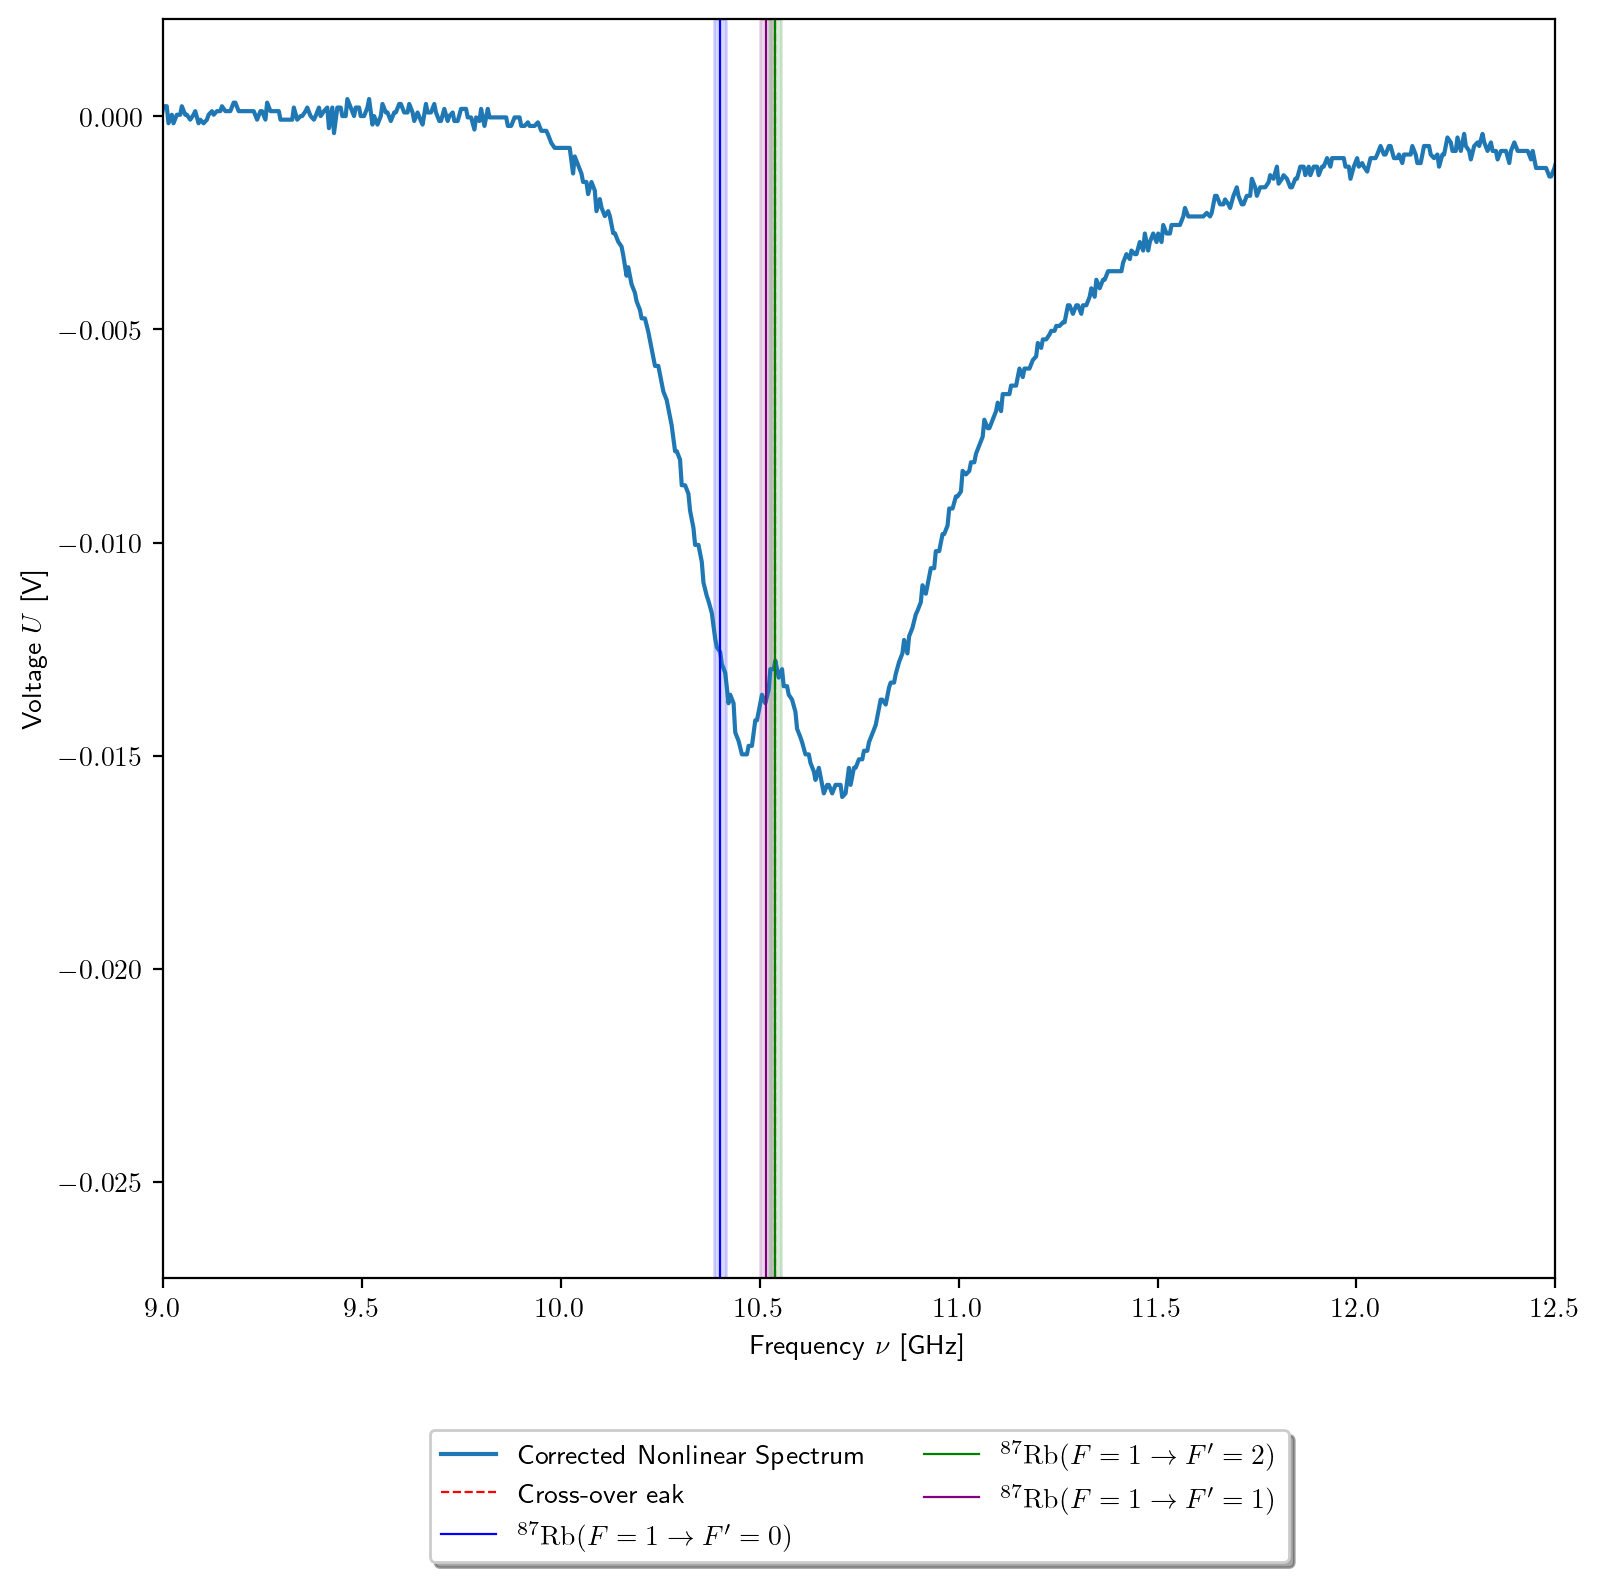

In [37]:
"""
Bestimmung Cross over peak -> Maxima
"""
# Intervall
xmin, xmax = 10.47, 10.6

# Maske fürs Intervall
mask = (freq_GHz >= xmin) & (freq_GHz <= xmax)

# Maximum im Intervall finden
idx_local = np.argmax(ch2_corr[mask])
idx_global = np.where(mask)[0][idx_local]

x_max = freq_GHz[idx_global]
y_max = ch2_corr[idx_global]

print(x_max)

"""
Bestimmung der excited states Übergänge -> Minima
"""
xmin1, xmax1 = 10.4, 10.5
mask1 = (freq_GHz >= xmin1) & (freq_GHz <= xmax1)
idx_loc1 = np.argmax(ch2_corr[mask1])
idx_glob1 = np.where(mask1)[0][idx_loc1]
x_min1 = freq_GHz[idx_glob1]
y_min1 = ch2_corr[idx_glob1]
xmin2, xmax2 = 10.50, 10.51
mask2 = (freq_GHz >= xmin2) & (freq_GHz <= xmax2)
idx_loc2 = np.argmax(ch2_corr[mask2])
idx_glob2 = np.where(mask2)[0][idx_loc2]
x_min2 = freq_GHz[idx_glob2]
y_min2 = ch2_corr[idx_glob2]
xmin3, xmax3 = 10.5, 10.8
mask3 = (freq_GHz >= xmin3) & (freq_GHz <= xmax3)
idx_loc3 = np.argmax(ch2_corr[mask3])
idx_glob3 = np.where(mask3)[0][idx_loc3]
x_min3 = freq_GHz[idx_glob3]
y_min3 = ch2_corr[idx_glob3]

delta = 0.015

plt.figure(figsize=(8,8), dpi=200)
plt.plot(freq_GHz, ch2_corr, label=r"Corrected Nonlinear Spectrum")
plt.xlabel(r"Frequency $\nu$ [GHz]")
plt.ylabel(r"Voltage $U$ [V]")
plt.axvline(x_max, linestyle="--", color="red", linewidth=0.8, label=r"Cross-over eak ")
plt.axvline(x_min1, linestyle="-", color="blue", linewidth=0.8, label=r"$^{87}\mathrm{Rb}(F=1 \rightarrow F'=0)$")
plt.axvline(x_min3, linestyle="-", color="green", linewidth=0.8, label=r"$^{87}\mathrm{Rb}(F=1 \rightarrow F'=2)$")
plt.axvline(10.515, linestyle="-", color="purple", linewidth=0.8, label=r"$^{87}\mathrm{Rb}(F=1 \rightarrow F'=1)$")

#fehlerbalken
plt.axvspan(x_min1 - delta, x_min1 + delta, color="blue", alpha=0.15)
plt.axvspan(10.515 - delta, 10.515 + delta, color="purple", alpha=0.15)
plt.axvspan(x_min3 - delta, x_min3 + delta, color="green", alpha=0.15)


plt.grid(False)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.11), fancybox=True, shadow=True, ncol=2)
plt.tight_layout()
plt.xlim(9,12.5)

plt.savefig("A2_Finesplitting_87Rb_1.pdf")
plt.show()

## Rubidium 85, F=2

7.052100840336131


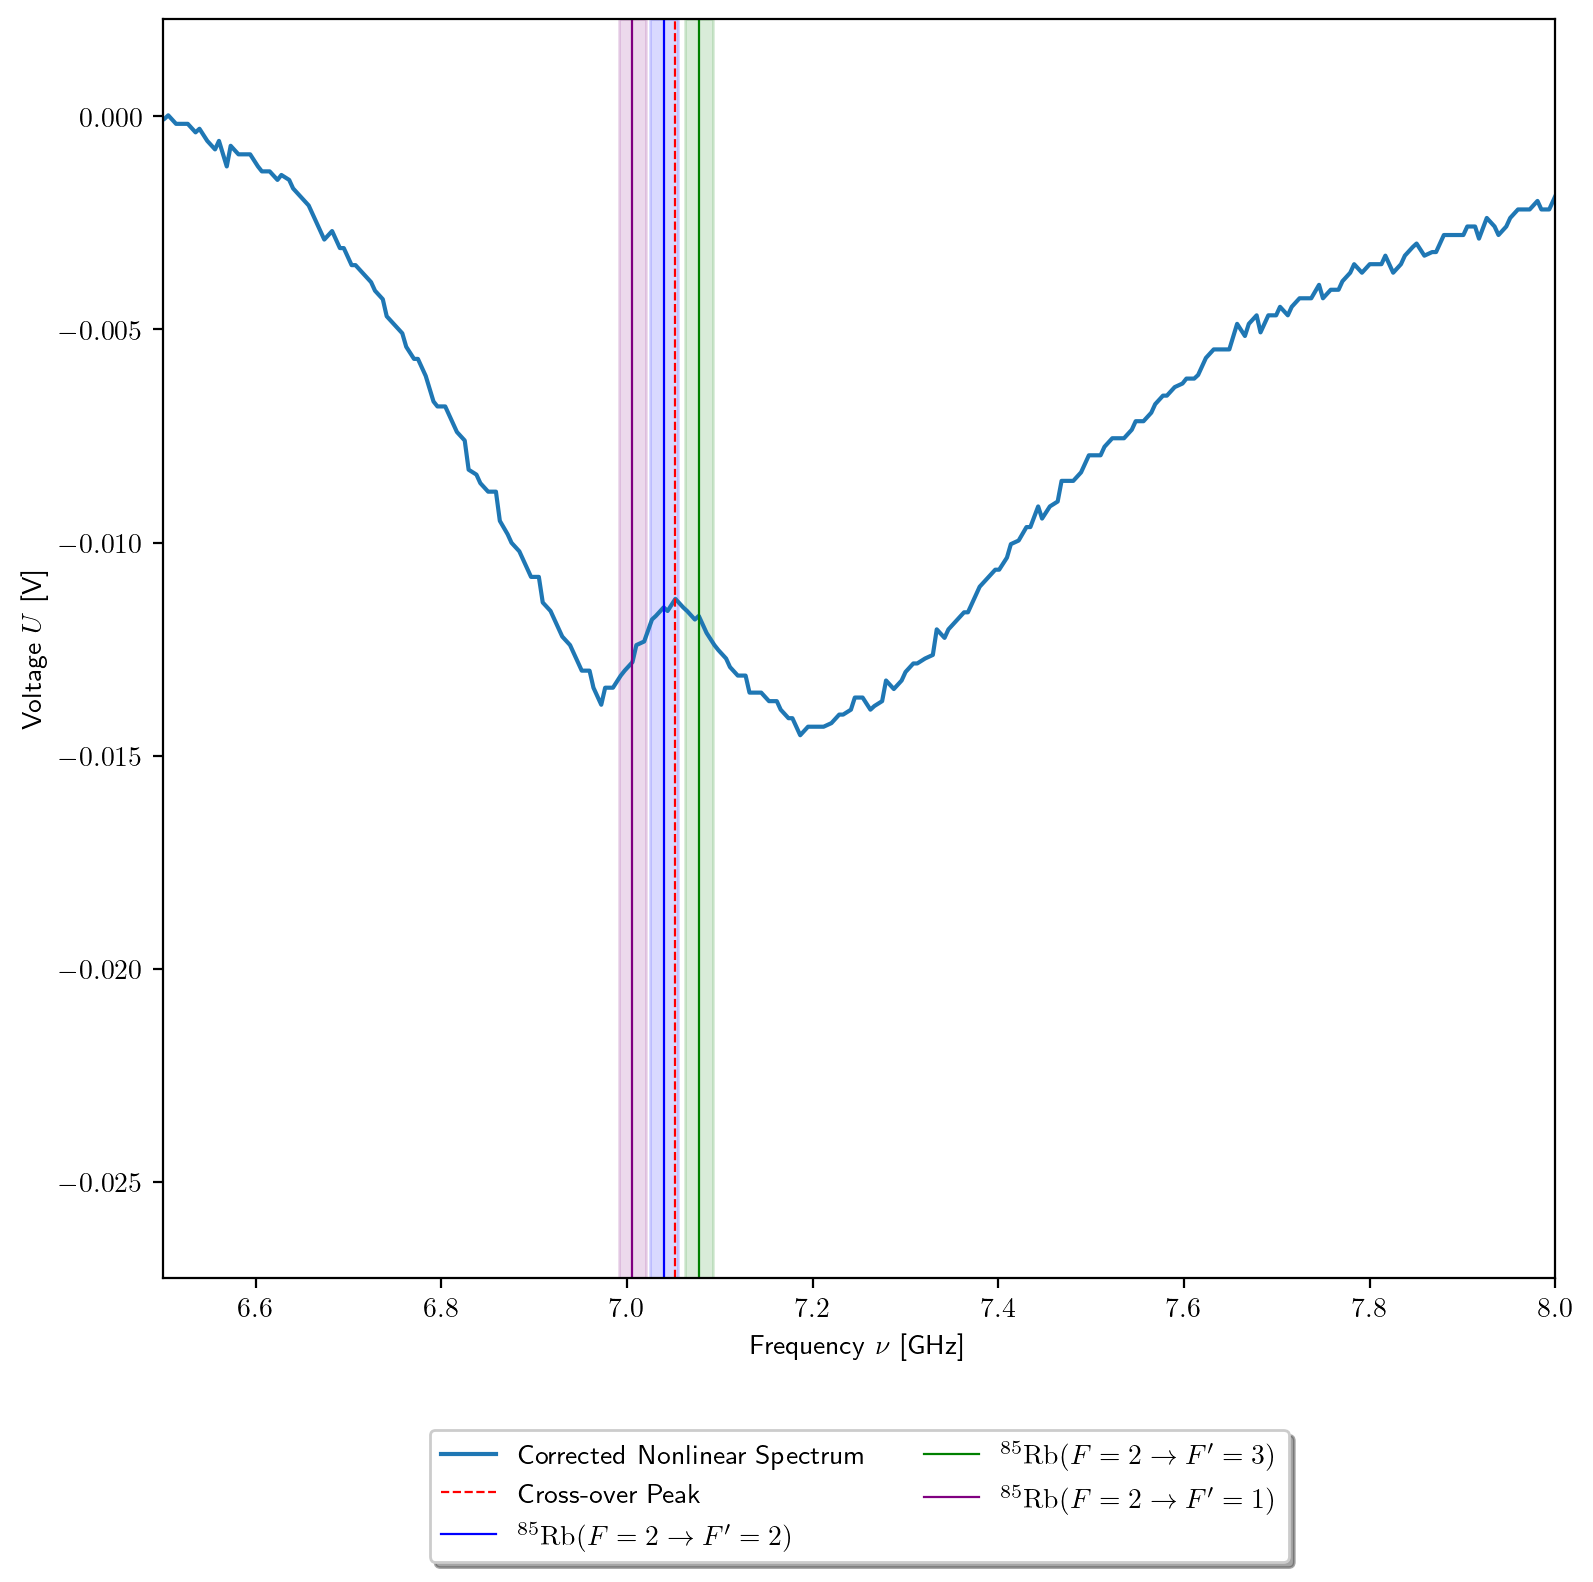

In [40]:
"""
Bestimmung Cross over peak -> Maxima
"""
# Intervall
xmin, xmax = 7.0, 7.2

# Maske fürs Intervall
mask = (freq_GHz >= xmin) & (freq_GHz <= xmax)

# Maximum im Intervall finden
idx_local = np.argmax(ch2_corr[mask])
idx_global = np.where(mask)[0][idx_local]

x_max = freq_GHz[idx_global]
y_max = ch2_corr[idx_global]

print(x_max)

"""
Bestimmung der excited states Übergänge -> Minima
"""
#xmin5, xmax5 = 7.0,7.1
#mask5 = (freq_GHz >= xmin5) & (freq_GHz <= xmax5)
#idx_loc5 = np.argmin(ch2_corr[mask5])
#idx_glob5 = np.where(mask5)[0][idx_loc5]
#x_min5 = freq_GHz[idx_glob5]
#y_min5 = ch2_corr[idx_glob5]
#xmin6, xmax6 = 7.0, 7.13
#mask6 = (freq_GHz >= xmin6) & (freq_GHz <= xmax6)
#idx_loc6 = np.argmin(ch2_corr[mask6])
#idx_glob6 = np.where(mask6)[0][idx_loc6]
#x_min6 = freq_GHz[idx_glob6]
#y_min6 = ch2_corr[idx_glob6]
#xmin4, xmax4 = 6.8, 7.0
#mask4 = (freq_GHz >= xmin4) & (freq_GHz <= xmax4)
#idx_loc4 = np.argmin(ch2_corr[mask4])
#idx_glob4 = np.where(mask4)[0][idx_loc4]
#x_min4 = freq_GHz[idx_glob4]
#y_min4 = ch2_corr[idx_glob4]

xmin5, xmax5 = 7.0,7.04
mask5 = (freq_GHz >= xmin5) & (freq_GHz <= xmax5)
idx_loc5 = np.argmax(ch2_corr[mask5])
idx_glob5 = np.where(mask5)[0][idx_loc5]
x_min5 = freq_GHz[idx_glob5]
y_min5 = ch2_corr[idx_glob5]
xmin6, xmax6 = 7.065, 7.13
mask6 = (freq_GHz >= xmin6) & (freq_GHz <= xmax6)
idx_loc6 = np.argmax(ch2_corr[mask6])
idx_glob6 = np.where(mask6)[0][idx_loc6]
x_min6 = freq_GHz[idx_glob6]
y_min6 = ch2_corr[idx_glob6]
xmin4, xmax4 = 7.0, 7.01
mask4 = (freq_GHz >= xmin4) & (freq_GHz <= xmax4)
idx_loc4 = np.argmax(ch2_corr[mask4])
idx_glob4 = np.where(mask4)[0][idx_loc4]
x_min4 = freq_GHz[idx_glob4]
y_min4 = ch2_corr[idx_glob4]


delta = 0.015

plt.figure(figsize=(8,8), dpi=200)
plt.plot(freq_GHz, ch2_corr, label=r"Corrected Nonlinear Spectrum")
plt.xlabel(r"Frequency $\nu$ [GHz]")
plt.ylabel(r"Voltage $U$ [V]")
plt.axvline(x_max, linestyle="--", color="red", linewidth=0.8, label=r"Cross-over Peak ")
plt.axvline(x_min5, linestyle="-", color="blue", linewidth=0.8, label=r"$^{85}\mathrm{Rb}(F=2 \rightarrow F'=2)$")
plt.axvline(x_min6, linestyle="-", color="green", linewidth=0.8, label=r"$^{85}\mathrm{Rb}(F=2 \rightarrow F'=3)$")
plt.axvline(x_min4, linestyle="-", color="purple", linewidth=0.8, label=r"$^{85}\mathrm{Rb}(F=2 \rightarrow F'=1)$")

#fehlerbalken
plt.axvspan(x_min5 - delta, x_min5 + delta, color="blue", alpha=0.15)
plt.axvspan(x_min6 - delta, x_min6 + delta, color="green", alpha=0.15)
plt.axvspan(x_min4 - delta, x_min4 + delta, color="purple", alpha=0.15)


plt.grid(False)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.11), fancybox=True, shadow=True, ncol=2)
plt.tight_layout()
plt.xlim(6.5,8)

plt.savefig("A2_Finesplitting_85Rb_2.pdf")
plt.show()

Cross-over (exp): 7.052100840336131 GHz
Exp F=2→F'=1: 7.005882352941175 GHz
Exp F=2→F'=2: 7.039495798319325 GHz
Exp F=2→F'=3: 7.077310924369746 GHz
Lit F=2→F'=1: 6.9910228403361305 GHz
Lit F=2→F'=2: 7.020374840336131 GHz
Lit F=2→F'=3: 7.083826840336131 GHz


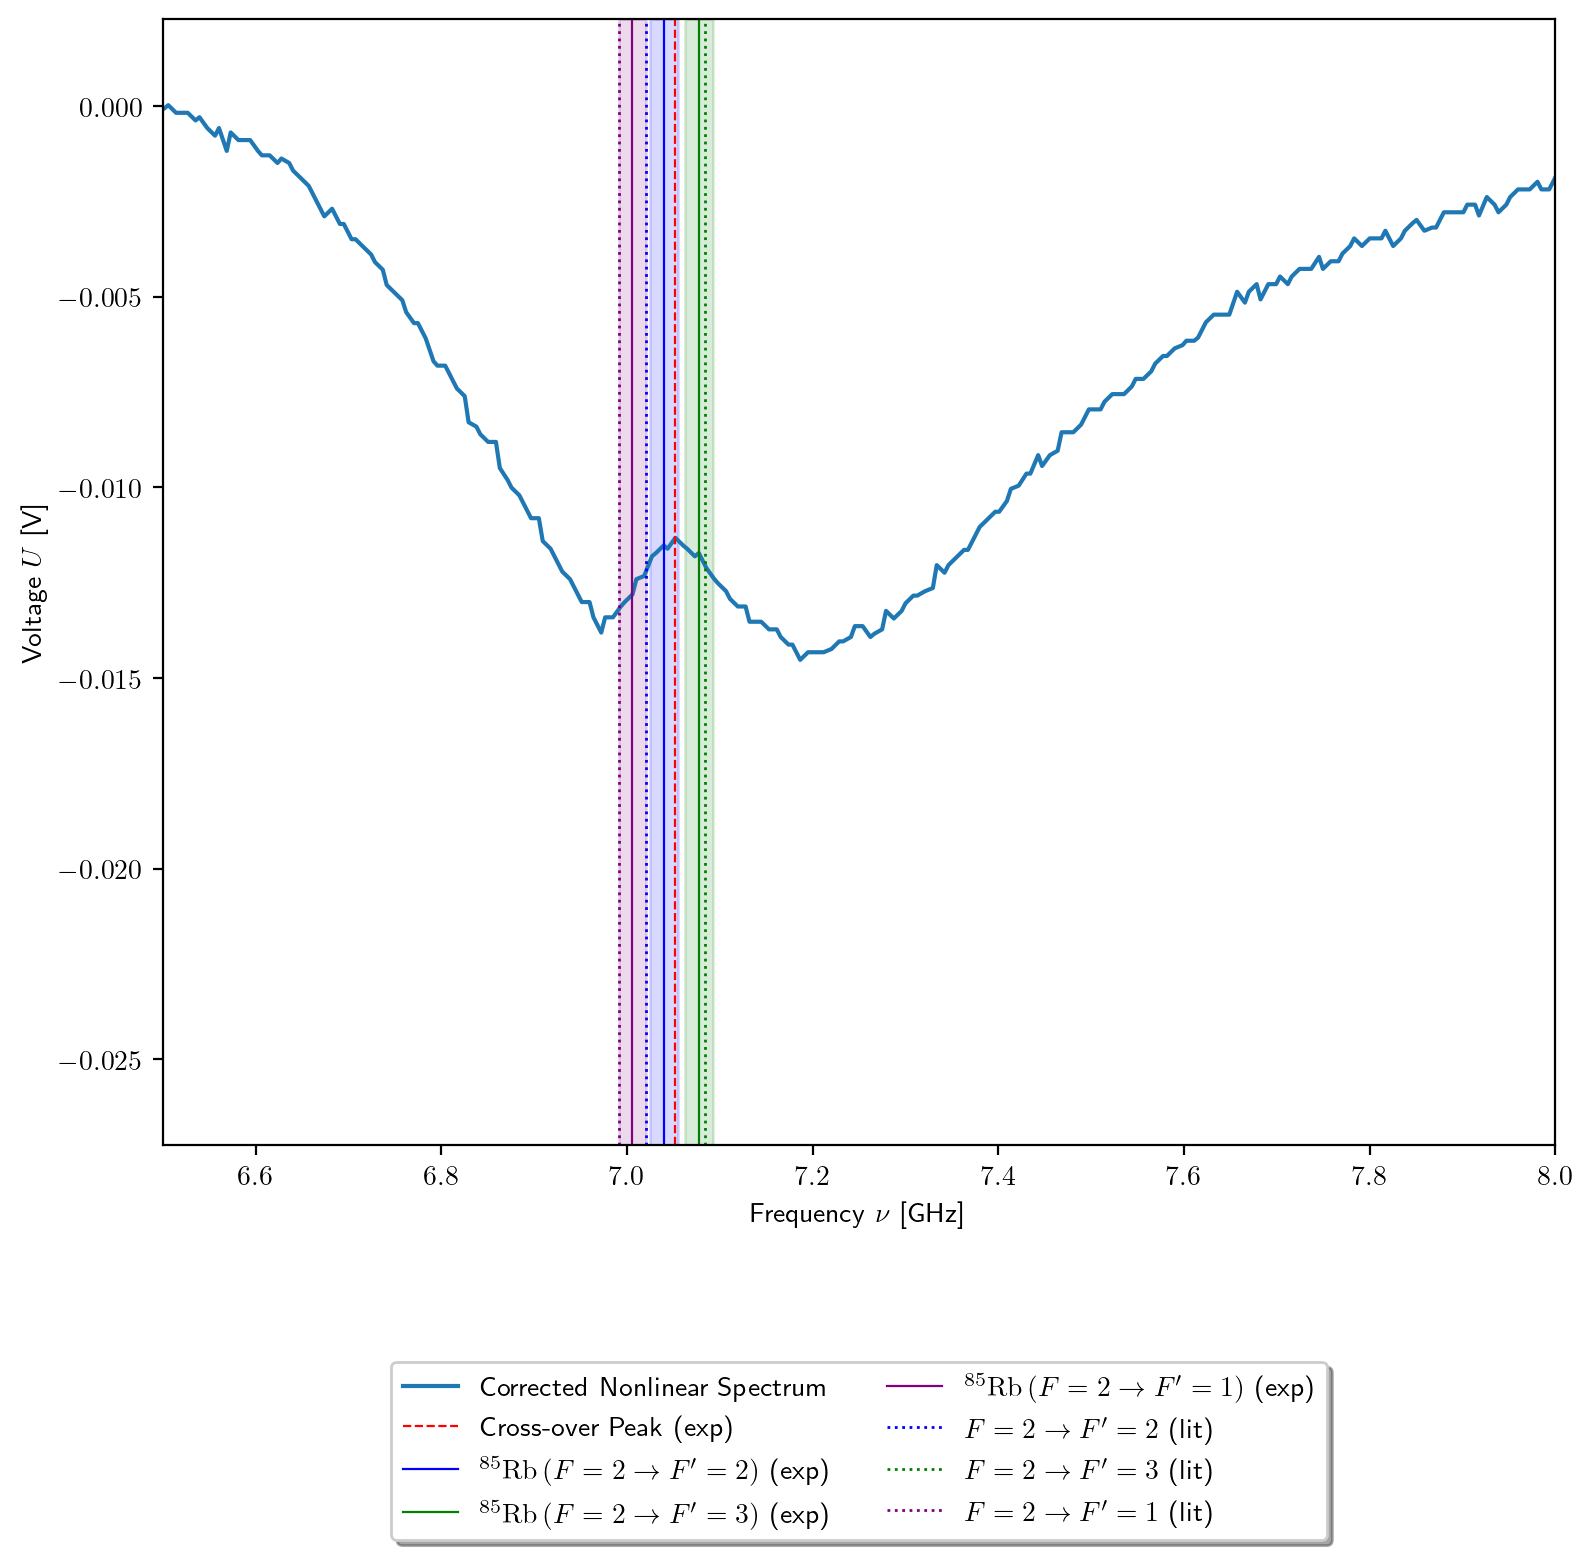

In [41]:
import numpy as np
import matplotlib.pyplot as plt

"""
Bestimmung Cross over peak -> Maxima
"""
# Intervall
xmin, xmax = 7.0, 7.2

# Maske fürs Intervall
mask = (freq_GHz >= xmin) & (freq_GHz <= xmax)

# Maximum im Intervall finden
idx_local = np.argmax(ch2_corr[mask])
idx_global = np.where(mask)[0][idx_local]

x_max = freq_GHz[idx_global]   # Cross-over F'=2/3
y_max = ch2_corr[idx_global]

print("Cross-over (exp):", x_max, "GHz")


"""
Bestimmung der excited states Übergänge -> Minima (experimentell)
"""
xmin5, xmax5 = 7.0,7.04
mask5 = (freq_GHz >= xmin5) & (freq_GHz <= xmax5)
idx_loc5 = np.argmax(ch2_corr[mask5])
idx_glob5 = np.where(mask5)[0][idx_loc5]
x_min5 = freq_GHz[idx_glob5]
y_min5 = ch2_corr[idx_glob5]
xmin6, xmax6 = 7.065, 7.13
mask6 = (freq_GHz >= xmin6) & (freq_GHz <= xmax6)
idx_loc6 = np.argmax(ch2_corr[mask6])
idx_glob6 = np.where(mask6)[0][idx_loc6]
x_min6 = freq_GHz[idx_glob6]
y_min6 = ch2_corr[idx_glob6]
xmin4, xmax4 = 7.0, 7.01
mask4 = (freq_GHz >= xmin4) & (freq_GHz <= xmax4)
idx_loc4 = np.argmax(ch2_corr[mask4])
idx_glob4 = np.where(mask4)[0][idx_loc4]
x_min4 = freq_GHz[idx_glob4]
y_min4 = ch2_corr[idx_glob4]



print("Exp F=2→F'=1:", x_min4, "GHz")
print("Exp F=2→F'=2:", x_min5, "GHz")
print("Exp F=2→F'=3:", x_min6, "GHz")

# Fehler (deine 0.015 GHz)
delta = 0.015


# ---------------------------------------------------------
# LITERATURWERTE FÜR EXCITED STATES (Positionen in GHz)
# ---------------------------------------------------------
Delta21_MHz = 29.352   # F'=2 - F'=1
Delta32_MHz = 63.452   # F'=3 - F'=2

Delta21_GHz = Delta21_MHz / 1000.0
Delta32_GHz = Delta32_MHz / 1000.0

nu_co = x_max   # Cross-over als Referenz

# Literaturpositionen der drei Übergänge (in GHz)
nu2_lit = nu_co - 0.5 * Delta32_GHz     # F=2 -> F'=2 (lit)
nu3_lit = nu_co + 0.5 * Delta32_GHz     # F=2 -> F'=3 (lit)
nu1_lit = nu2_lit - Delta21_GHz         # F=2 -> F'=1 (lit)

print("Lit F=2→F'=1:", nu1_lit, "GHz")
print("Lit F=2→F'=2:", nu2_lit, "GHz")
print("Lit F=2→F'=3:", nu3_lit, "GHz")


# ---------------------------------------------------------
# PLOT
# ---------------------------------------------------------
plt.figure(figsize=(8,8), dpi=200)
plt.plot(freq_GHz, ch2_corr, label=r"Corrected Nonlinear Spectrum")
plt.xlabel(r"Frequency $\nu$ [GHz]")
plt.ylabel(r"Voltage $U$ [V]")

# Cross-over Peak (exp)
plt.axvline(x_max, linestyle="--", color="red", linewidth=0.8,
            label=r"Cross-over Peak (exp)")

# Experimentelle Übergänge
plt.axvline(x_min5, linestyle="-", color="blue", linewidth=0.8,
            label=r"$^{85}\mathrm{Rb}\,(F=2 \rightarrow F'=2)$ (exp)")
plt.axvline(x_min6, linestyle="-", color="green", linewidth=0.8,
            label=r"$^{85}\mathrm{Rb}\,(F=2 \rightarrow F'=3)$ (exp)")
plt.axvline(x_min4, linestyle="-", color="purple", linewidth=0.8,
            label=r"$^{85}\mathrm{Rb}\,(F=2 \rightarrow F'=1)$ (exp)")

# Fehlerbalken (exp)
plt.axvspan(x_min5 - delta, x_min5 + delta, color="blue", alpha=0.15)
plt.axvspan(x_min6 - delta, x_min6 + delta, color="green", alpha=0.15)
plt.axvspan(x_min4 - delta, x_min4 + delta, color="purple", alpha=0.15)

# Literatur-Übergänge (als gestrichelte Linien)
plt.axvline(nu2_lit, linestyle=":", color="blue", linewidth=1.0,
            label=r"$F=2 \rightarrow F'=2$ (lit)")
plt.axvline(nu3_lit, linestyle=":", color="green", linewidth=1.0,
            label=r"$F=2 \rightarrow F'=3$ (lit)")
plt.axvline(nu1_lit, linestyle=":", color="purple", linewidth=1.0,
            label=r"$F=2 \rightarrow F'=1$ (lit)")

plt.grid(False)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.18),
           fancybox=True, shadow=True, ncol=2)
plt.tight_layout()
plt.xlim(6.5, 8)

plt.savefig("A2_Finesplitting_85Rb_2_with_lit.pdf")
plt.show()


## Rubidium 85, F=3

4.052100840336133
Lit F=3→F'=2: 3.8878085042016797 GHz
Lit F=3→F'=3: 3.9512605042016795 GHz
Lit F=3→F'=4: 4.0721205042016795 GHz


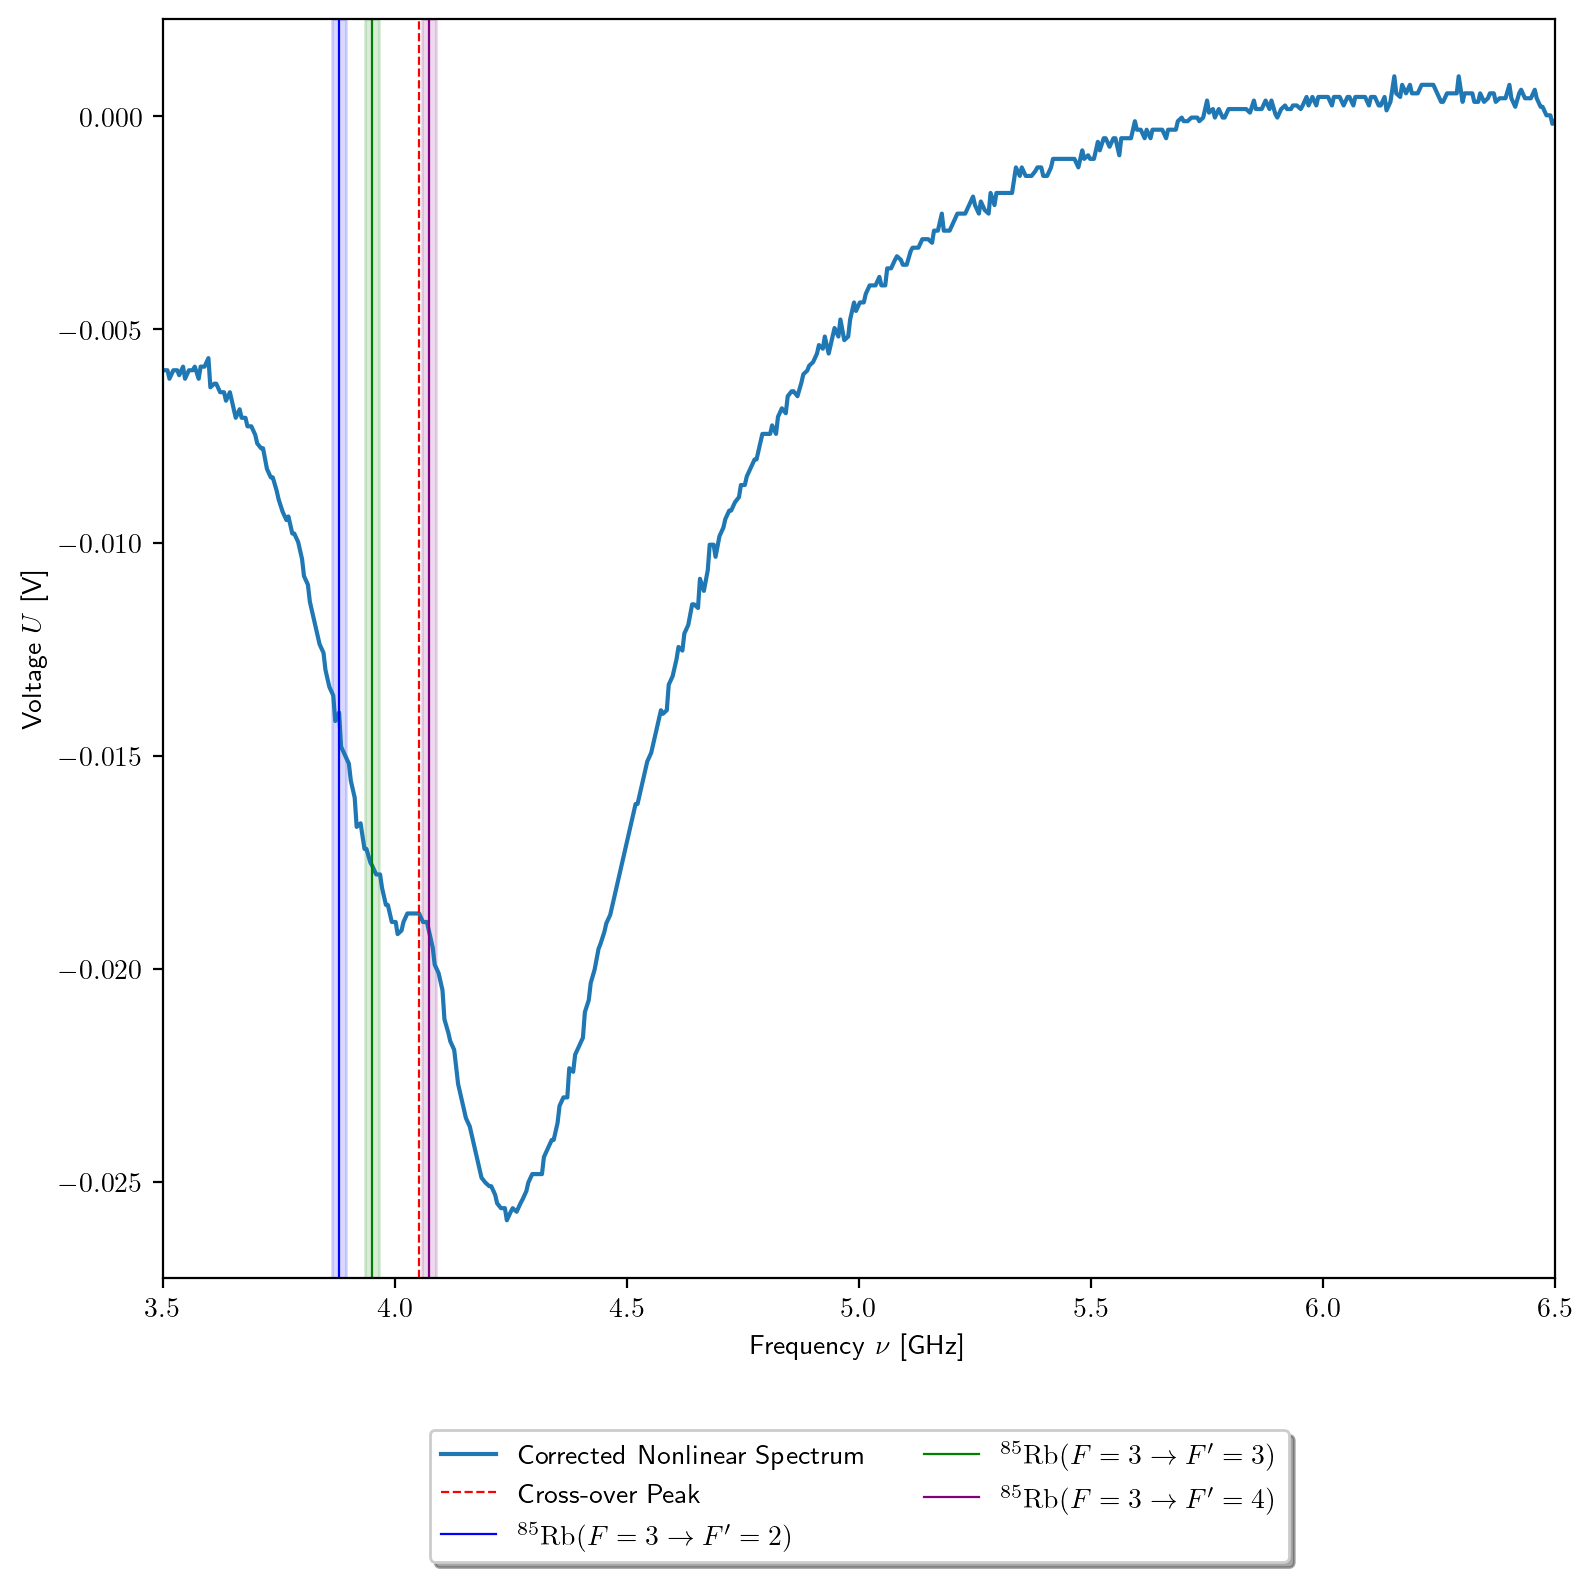

In [42]:
"""
Bestimmung Cross over peak -> Maxima
"""
# Intervall
xmin, xmax = 4.05, 4.1

# Maske fürs Intervall
mask = (freq_GHz >= xmin) & (freq_GHz <= xmax)

# Maximum im Intervall finden
idx_local = np.argmax(ch2_corr[mask])
idx_global = np.where(mask)[0][idx_local]

x_max = freq_GHz[idx_global]
y_max = ch2_corr[idx_global]

print(x_max)

"""
Bestimmung der excited states Übergänge -> Minima
"""
xmin7, xmax7 = 3.87, 3.93
mask7 = (freq_GHz >= xmin7) & (freq_GHz <= xmax7)
idx_loc7 = np.argmax(ch2_corr[mask7])
idx_glob7 = np.where(mask7)[0][idx_loc7]
x_min7 = freq_GHz[idx_glob7]
y_min7 = ch2_corr[idx_glob7]
xmin8, xmax8 = 3.95, 4.05
mask8 = (freq_GHz >= xmin8) & (freq_GHz <= xmax8)
idx_loc8 = np.argmax(ch2_corr[mask8])
idx_glob8 = np.where(mask8)[0][idx_loc8]
x_min8 = freq_GHz[idx_glob8]
y_min8 = ch2_corr[idx_glob8]
xmin9, xmax9 = 4.07, 4.15
mask9 = (freq_GHz >= xmin9) & (freq_GHz <= xmax9)
idx_loc9 = np.argmax(ch2_corr[mask9])
idx_glob9 = np.where(mask9)[0][idx_loc9]
x_min9 = freq_GHz[idx_glob9]
y_min9 = ch2_corr[idx_glob9]

delta = 0.015

plt.figure(figsize=(8,8), dpi=200)
plt.plot(freq_GHz, ch2_corr, label=r"Corrected Nonlinear Spectrum")
plt.xlabel(r"Frequency $\nu$ [GHz]")
plt.ylabel(r"Voltage $U$ [V]")
plt.axvline(x_max, linestyle="--", color="red", linewidth=0.8, label=r"Cross-over Peak ")
plt.axvline(x_min7, linestyle="-", color="blue", linewidth=0.8, label=r"$^{85}\mathrm{Rb}(F=3 \rightarrow F'=2)$")
plt.axvline(x_min8, linestyle="-", color="green", linewidth=0.8, label=r"$^{85}\mathrm{Rb}(F=3 \rightarrow F'=3)$")
plt.axvline(x_min9, linestyle="-", color="purple", linewidth=0.8, label=r"$^{85}\mathrm{Rb}(F=3 \rightarrow F'=4)$")

#fehlerbalken
plt.axvspan(x_min7 - delta, x_min7 + delta, color="blue", alpha=0.15)
plt.axvspan(x_min8 - delta, x_min8 + delta, color="green", alpha=0.15)
plt.axvspan(x_min9 - delta, x_min9 + delta, color="purple", alpha=0.15)

# -----------------------------------------
# Literaturwerte für excited state (in GHz)
# -----------------------------------------

Delta32_GHz = 63.452 / 1000.0      # F'=3 - F'=2
Delta43_GHz = 120.860 / 1000.0     # F'=4 - F'=3

# Deine gemessene F=3 → F'=3 Position:
nu3_exp = x_min8

# Literaturpositionen:
nu2_lit_F3 = nu3_exp - Delta32_GHz
nu3_lit_F3 = nu3_exp
nu4_lit_F3 = nu3_exp + Delta43_GHz

print("Lit F=3→F'=2:", nu2_lit_F3, "GHz")
print("Lit F=3→F'=3:", nu3_lit_F3, "GHz")
print("Lit F=3→F'=4:", nu4_lit_F3, "GHz")

# Plot:
#plt.axvline(nu2_lit_F3, linestyle=":", color="blue",
#            label=r"$^{85}$Rb $(F=3\rightarrow F'=2)$ (lit)")
#plt.axvline(nu3_lit_F3, linestyle=":", color="green",
#            label=r"$^{85}$Rb $(F=3\rightarrow F'=3)$ (lit)")
#plt.axvline(nu4_lit_F3, linestyle=":", color="purple",
#            label=r"$^{85}$Rb $(F=3\rightarrow F'=4)$ (lit)")



plt.grid(False)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.11), fancybox=True, shadow=True, ncol=2)
plt.tight_layout()
plt.xlim(3.5,6.5)

plt.savefig("A2_Finesplitting_85Rb_3.pdf")
plt.show()

4.052100840336133
Lit F=3→F'=2: 3.8878085042016797 GHz
Lit F=3→F'=3: 3.9512605042016795 GHz
Lit F=3→F'=4: 4.0721205042016795 GHz


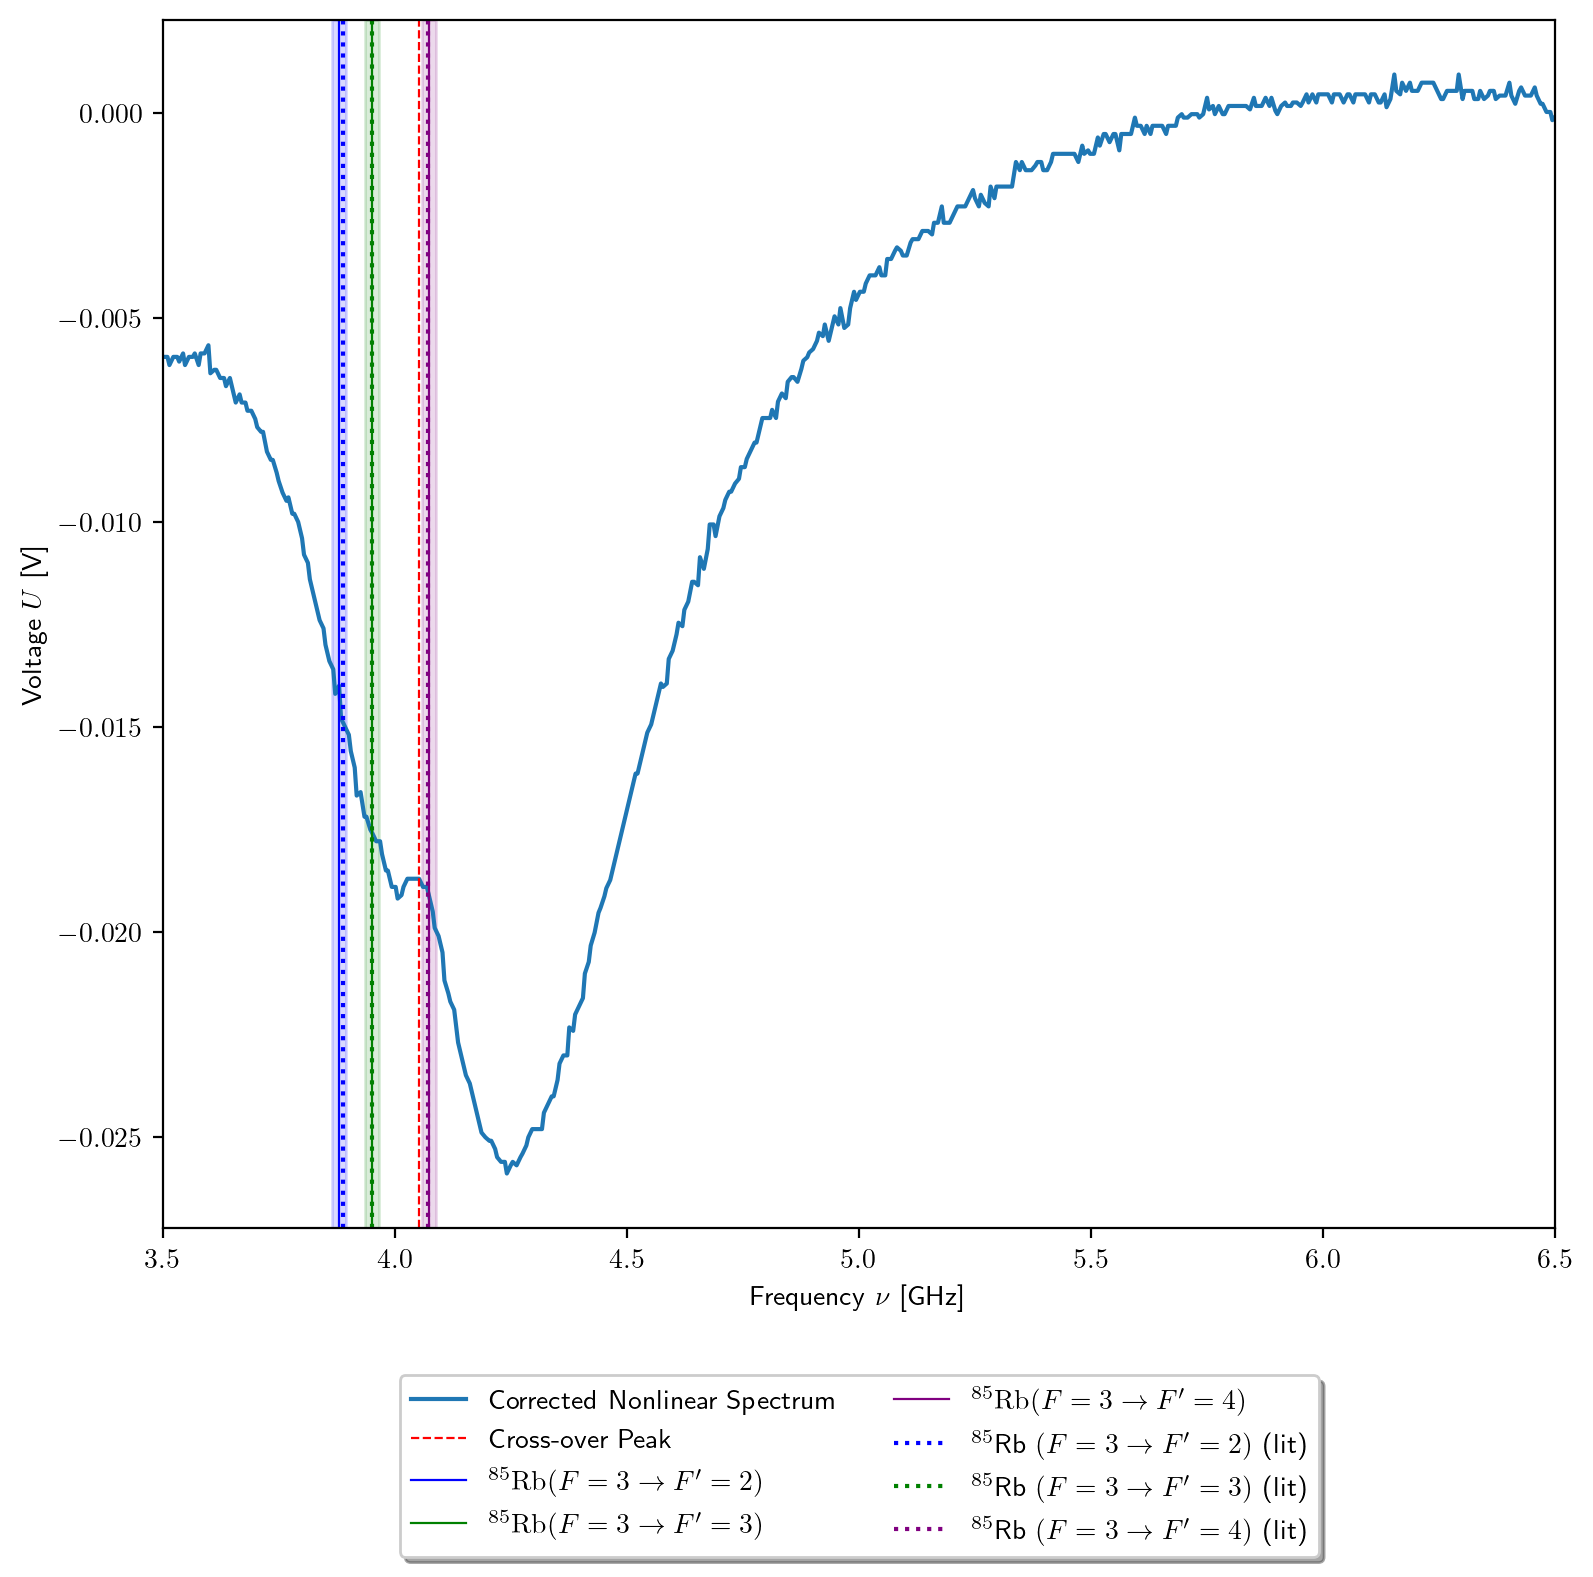

In [43]:
"""
Bestimmung Cross over peak -> Maxima
"""
# Intervall
xmin, xmax = 4.05, 4.1

# Maske fürs Intervall
mask = (freq_GHz >= xmin) & (freq_GHz <= xmax)

# Maximum im Intervall finden
idx_local = np.argmax(ch2_corr[mask])
idx_global = np.where(mask)[0][idx_local]

x_max = freq_GHz[idx_global]
y_max = ch2_corr[idx_global]

print(x_max)

"""
Bestimmung der excited states Übergänge -> Minima
"""
xmin7, xmax7 = 3.87, 3.93
mask7 = (freq_GHz >= xmin7) & (freq_GHz <= xmax7)
idx_loc7 = np.argmax(ch2_corr[mask7])
idx_glob7 = np.where(mask7)[0][idx_loc7]
x_min7 = freq_GHz[idx_glob7]
y_min7 = ch2_corr[idx_glob7]
xmin8, xmax8 = 3.95, 4.05
mask8 = (freq_GHz >= xmin8) & (freq_GHz <= xmax8)
idx_loc8 = np.argmax(ch2_corr[mask8])
idx_glob8 = np.where(mask8)[0][idx_loc8]
x_min8 = freq_GHz[idx_glob8]
y_min8 = ch2_corr[idx_glob8]
xmin9, xmax9 = 4.07, 4.15
mask9 = (freq_GHz >= xmin9) & (freq_GHz <= xmax9)
idx_loc9 = np.argmax(ch2_corr[mask9])
idx_glob9 = np.where(mask9)[0][idx_loc9]
x_min9 = freq_GHz[idx_glob9]
y_min9 = ch2_corr[idx_glob9]

delta = 0.015

plt.figure(figsize=(8,8), dpi=200)
plt.plot(freq_GHz, ch2_corr, label=r"Corrected Nonlinear Spectrum")
plt.xlabel(r"Frequency $\nu$ [GHz]")
plt.ylabel(r"Voltage $U$ [V]")
plt.axvline(x_max, linestyle="--", color="red", linewidth=0.8, label=r"Cross-over Peak ")
plt.axvline(x_min7, linestyle="-", color="blue", linewidth=0.8, label=r"$^{85}\mathrm{Rb}(F=3 \rightarrow F'=2)$")
plt.axvline(x_min8, linestyle="-", color="green", linewidth=0.8, label=r"$^{85}\mathrm{Rb}(F=3 \rightarrow F'=3)$")
plt.axvline(x_min9, linestyle="-", color="purple", linewidth=0.8, label=r"$^{85}\mathrm{Rb}(F=3 \rightarrow F'=4)$")

#fehlerbalken
plt.axvspan(x_min7 - delta, x_min7 + delta, color="blue", alpha=0.15)
plt.axvspan(x_min8 - delta, x_min8 + delta, color="green", alpha=0.15)
plt.axvspan(x_min9 - delta, x_min9 + delta, color="purple", alpha=0.15)

# -----------------------------------------
# Literaturwerte für excited state (in GHz)
# -----------------------------------------

Delta32_GHz = 63.452 / 1000.0      # F'=3 - F'=2
Delta43_GHz = 120.860 / 1000.0     # F'=4 - F'=3

# Deine gemessene F=3 → F'=3 Position:
nu3_exp = x_min8

# Literaturpositionen:
nu2_lit_F3 = nu3_exp - Delta32_GHz
nu3_lit_F3 = nu3_exp
nu4_lit_F3 = nu3_exp + Delta43_GHz

print("Lit F=3→F'=2:", nu2_lit_F3, "GHz")
print("Lit F=3→F'=3:", nu3_lit_F3, "GHz")
print("Lit F=3→F'=4:", nu4_lit_F3, "GHz")

# Plot:
plt.axvline(nu2_lit_F3, linestyle=":", color="blue",
            label=r"$^{85}$Rb $(F=3\rightarrow F'=2)$ (lit)")
plt.axvline(nu3_lit_F3, linestyle=":", color="green",
            label=r"$^{85}$Rb $(F=3\rightarrow F'=3)$ (lit)")
plt.axvline(nu4_lit_F3, linestyle=":", color="purple",
            label=r"$^{85}$Rb $(F=3\rightarrow F'=4)$ (lit)")



plt.grid(False)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.11), fancybox=True, shadow=True, ncol=2)
plt.tight_layout()
plt.xlim(3.5,6.5)

plt.savefig("A2_Finesplitting_85Rb_3_with_lit.pdf")
plt.show()

## Rb 87, F=2

## Computation of constants of Rb 85 -> I=5/2, J=3/2, F'=1,2,3,4

In [31]:
import numpy as np

# -------------------------------------------------------
# 1) HIER DEINE SECHS PEAK-POSITIONEN EINTRAGEN (MHz)
# Beispielwerte als Platzhalter:
nu_2to1 = x_min4     # F=2 -> F'=1
nu_2to2 = x_min5    # F=2 -> F'=2
nu_2to3 = x_min6    # F=2 -> F'=3

nu_3to2 = x_min7    # F=3 -> F'=2
nu_3to3 = x_min8    # F=3 -> F'=3
nu_3to4 = x_min9    # F=3 -> F'=4
# -------------------------------------------------------


# -------------------------------------------------------
# 2) DIFFERENCES BERECHNEN
Delta_21 = nu_2to2 - nu_2to1               # ν2 - ν1
Delta_32_2 = nu_2to3 - nu_2to2             # ν3 - ν2 (aus F=2)
Delta_32_3 = nu_3to3 - nu_3to2             # ν3 - ν2 (aus F=3)
Delta_32 = (Delta_32_2 + Delta_32_3) / 2   # gemittelter besserer Wert

Delta_43 = nu_3to4 - nu_3to3               # ν4 - ν3
# -------------------------------------------------------
print(Delta_32_2)
print(Delta_32_3)
print(Delta_43)
print(Delta_21)

# -------------------------------------------------------
# 3) RELATIVE ENERGIEN ν1,ν2,ν3,ν4 KONSTRUieren
nu3 = 0.0
nu4 = Delta_43
nu2 = -Delta_32
nu1 = -Delta_21 - Delta_32

nu_vec = np.array([nu1, nu2, nu3, nu4])  # in MHz
# -------------------------------------------------------

# -------------------------------------------------------
# 4) K-F und Q-F-WERTE FÜR 85Rb  (F'=1..4)
# aus der Tabelle
alpha = np.array([-5.25, -3.25, -0.25, 3.75])  # K/2
Q =     np.array([ 1.4 , -0.2 , -1.1 , 0.5 ])  # Q_F

M = np.column_stack((alpha, Q))  # Design-Matrix 4×2
# -------------------------------------------------------


# -------------------------------------------------------
# 5) LEAST-SQUARES FIT
A_hfs, B_hfs = np.linalg.lstsq(M, nu_vec, rcond=None)[0]

print("=====================================")
print("Hyperfeinkonstanten (Ergebnis):")
print(f"A_hfs = {A_hfs:.4f}   MHz")
print(f"B_hfs = {B_hfs:.4f}   MHz")
print("=====================================")


0.03781512605042092
0.07142857142857162
0.12184873949579833
0.03361344537815025
Hyperfeinkonstanten (Ergebnis):
A_hfs = 0.0223   MHz
B_hfs = 0.0143   MHz


## Computing seperately for F=2 and F=3

In [32]:
import numpy as np

# -------------------------------------------------------
# 1) HIER DEINE PEAK-POSITIONEN EINTRAGEN (MHz)
# F = 2 → F' = 1,2,3
nu_2to1 = x_min4
nu_2to2 = x_min5
nu_2to3 = x_min6

# F = 3 → F' = 2,3,4
nu_3to2 = x_min7
nu_3to3 = x_min8
nu_3to4 = x_min9
# -------------------------------------------------------
sigma_peak = 15.0  # MHz
sigma_diff = np.sqrt(2) * sigma_peak  # Fehler der Differences
sigma_level = sigma_diff 

# -------------------------------------------------------
# FALL A: Nur F = 2 → F' = 1,2,3
print("=== FALL A: F = 2 → F' = 1,2,3 ===")

# Differences aus diesem Fall:
Delta_21_A = nu_2to2 - nu_2to1     # ν2 - ν1
Delta_32_A = nu_2to3 - nu_2to2     # ν3 - ν2

print("Δ21 (F'=2 - F'=1) =", Delta_21_A)
print("Δ32 (F'=3 - F'=2) =", Delta_32_A)
print(sigma_diff)

# Niveaus relativ konstruieren (ν3 = 0)
nu3_A = 0.0
nu2_A = -Delta_32_A
nu1_A = -Delta_21_A - Delta_32_A
nu_vec_A = np.array([nu1_A, nu2_A, nu3_A])
sigma_nu_vec_A = np.array([sigma_level, sigma_level, 0.0])

print("ν1, ν2, ν3 =", nu_vec_A)
print("σ(ν1,ν2,ν3) =", sigma_nu_vec_A)

print()


# -------------------------------------------------------
# FALL B: Nur F = 3 → F' = 2,3,4
print("=== FALL B: F = 3 → F' = 2,3,4 ===")

Delta_32_B = nu_3to3 - nu_3to2     # ν3 - ν2
Delta_43_B = nu_3to4 - nu_3to3     # ν4 - ν3

print("Δ32 (F'=3 - F'=2) =", Delta_32_B)
print("Δ43 (F'=4 - F'=3) =", Delta_43_B)

# Niveaus relativ konstruieren (ν3 = 0)
nu3_B = 0.0
nu2_B = -Delta_32_B
nu4_B = Delta_43_B
nu_vec_B = np.array([nu2_B, nu3_B, nu4_B])
sigma_nu_vec_B = np.array([sigma_level, 0.0, sigma_level])

print("ν2, ν3, ν4 =", nu_vec_B)
print("σ(ν2,ν3,ν4) =", sigma_nu_vec_B)
print()


# -------------------------------------------------------
# GESAMTFALL: F=2 und F=3 kombiniert → Fit für A,B
print("=== GESAMTFIT für A_hfs und B_hfs ===")

# Weighted Δ32 aus beiden Fällen:
# → falls du Fehler hast, kannst du das später erweitern
Delta_21 = Delta_21_A
Delta_32 = (Delta_32_A + Delta_32_B) / 2
Delta_43 = Delta_43_B

# Energieschema komplett:
nu3 = 0.0
nu4 = Delta_43
nu2 = -Delta_32
nu1 = -Delta_21 - Delta_32

nu_vec = np.array([nu1, nu2, nu3, nu4])

# HFS-Koeffizienten für 85Rb
alpha = np.array([-5.25, -3.25, -0.25, 3.75])  # K/2
Q     = np.array([ 1.4 , -0.2 , -1.1 , 0.5 ])  # Q_F

M = np.column_stack((alpha, Q))

A_hfs, B_hfs = np.linalg.lstsq(M, nu_vec, rcond=None)[0]

print("A_hfs =", A_hfs)
print("B_hfs =", B_hfs)
print("=====================================")


=== FALL A: F = 2 → F' = 1,2,3 ===
Δ21 (F'=2 - F'=1) = 0.03361344537815025
Δ32 (F'=3 - F'=2) = 0.03781512605042092
21.213203435596427
ν1, ν2, ν3 = [-0.07142857 -0.03781513  0.        ]
σ(ν1,ν2,ν3) = [21.21320344 21.21320344  0.        ]

=== FALL B: F = 3 → F' = 2,3,4 ===
Δ32 (F'=3 - F'=2) = 0.07142857142857162
Δ43 (F'=4 - F'=3) = 0.12184873949579833
ν2, ν3, ν4 = [-0.07142857  0.          0.12184874]
σ(ν2,ν3,ν4) = [21.21320344  0.         21.21320344]

=== GESAMTFIT für A_hfs und B_hfs ===
A_hfs = 0.022256381196302806
B_hfs = 0.01433117403880666


In [34]:
import numpy as np

# -------------------------------------------------------
# 1) HIER DEINE PEAK-POSITIONEN EINTRAGEN (MHz)
# F = 2 → F' = 1,2,3
nu_2to1 = x_min4
nu_2to2 = x_min5
nu_2to3 = x_min6

# F = 3 → F' = 2,3,4
nu_3to2 = x_min7
nu_3to3 = x_min8
nu_3to4 = x_min9
# -------------------------------------------------------
sigma_peak = 0.0150  # MHz
sigma_diff = np.sqrt(2) * sigma_peak  # Fehler der Differences

# -------------------------------------------------------
# FALL A: Nur F = 2 → F' = 1,2,3
print("=== FALL A: F = 2 → F' = 1,2,3 ===")

# Differences aus diesem Fall:
Delta_21_A = nu_2to2 - nu_2to1     # ν2 - ν1
Delta_32_A = nu_2to3 - nu_2to2     # ν3 - ν2

print("Δ21 (F'=2 - F'=1) =", Delta_21_A)
print("Δ32 (F'=3 - F'=2) =", Delta_32_A)
print("σ(Δ) =", sigma_diff)

# Niveaus relativ konstruieren (ν3 = 0)
nu3_A = 0.0
nu2_A = -Delta_32_A
nu1_A = -Delta_21_A - Delta_32_A
nu_vec_A = np.array([nu1_A, nu2_A, nu3_A])
sigma_level = sigma_diff  # grobe Abschätzung wie vorher
sigma_nu_vec_A = np.array([sigma_level, sigma_level, 0.0])

print("ν1, ν2, ν3 =", nu_vec_A)
print("σ(ν1,ν2,ν3) =", sigma_nu_vec_A)
print()

# -------------------------------------------------------
# FALL B: Nur F = 3 → F' = 2,3,4
print("=== FALL B: F = 3 → F' = 2,3,4 ===")

Delta_32_B = nu_3to3 - nu_3to2     # ν3 - ν2
Delta_43_B = nu_3to4 - nu_3to3     # ν4 - ν3

print("Δ32 (F'=3 - F'=2) =", Delta_32_B)
print("Δ43 (F'=4 - F'=3) =", Delta_43_B)
print("σ(Δ32_B), σ(Δ43_B) ≈", sigma_diff, sigma_diff)

# Niveaus relativ konstruieren (ν3 = 0)
nu3_B = 0.0
nu2_B = -Delta_32_B
nu4_B = Delta_43_B
nu_vec_B = np.array([nu2_B, nu3_B, nu4_B])
sigma_nu_vec_B = np.array([sigma_level, 0.0, sigma_level])

print("ν2, ν3, ν4 =", nu_vec_B)
print("σ(ν2,ν3,ν4) =", sigma_nu_vec_B)
print()

# -------------------------------------------------------
# GESAMTFALL: F=2 und F=3 kombiniert → Fit für A_hfs und B_hfs
print("=== GESAMTFIT für A_hfs und B_hfs ===")

# Weighted Δ32 aus beiden Fällen:
Delta_21 = Delta_21_A
Delta_32 = (Delta_32_A + Delta_32_B) / 2.0
Delta_43 = Delta_43_B

# -------------------------------
# GAUSSSCHE FEHLERPROPAGATION FÜR DIE Δs
# Alle Differenzen haben zunächst denselben Fehler sigma_diff
sigma_D21 = sigma_diff
sigma_D32_A = sigma_diff
sigma_D32_B = sigma_diff
sigma_D43 = sigma_diff

# σ(Δ32) aus Mittelwert von Δ32_A und Δ32_B:
# Δ32 = (Δ32_A + Δ32_B)/2 ⇒ Var(Δ32) = (1/4)(σ_A^2 + σ_B^2)
sigma_D32 = 0.5 * np.sqrt(sigma_D32_A**2 + sigma_D32_B**2)

print("σ(Δ21) =", sigma_D21)
print("σ(Δ32) =", sigma_D32)
print("σ(Δ43) =", sigma_D43)

# -------------------------------
# GAUSSSCHE FEHLERPROPAGATION FÜR DIE NIVEAUS ν1..ν4

# Energieschema komplett:
nu3 = 0.0
nu4 = Delta_43
nu2 = -Delta_32
nu1 = -Delta_21 - Delta_32

nu_vec = np.array([nu1, nu2, nu3, nu4])

# σ(ν2) = σ(Δ32)
sigma_nu2 = sigma_D32
# σ(ν1)^2 = σ(Δ21)^2 + σ(Δ32)^2 (Voraussetzung: unabhängig)
sigma_nu1 = np.sqrt(sigma_D21**2 + sigma_D32**2)
# ν3 ist Referenz, daher hier fehlerfrei gesetzt
sigma_nu3 = 0.0
# σ(ν4) = σ(Δ43)
sigma_nu4 = sigma_D43

sigma_nu_vec = np.array([sigma_nu1, sigma_nu2, sigma_nu3, sigma_nu4])

print("ν1..ν4 =", nu_vec)
print("σ(ν1..ν4) =", sigma_nu_vec)
print()

# -------------------------------------------------------
# LINEARES MODELL FÜR DIE HFS-KOEFFIZIENTEN
# HFS-Koeffizienten für 85Rb
alpha = np.array([-5.25, -3.25, -0.25,  3.75])  # K/2
Q     = np.array([ 1.4 , -0.2 , -1.1 ,  0.5 ])  # Q_F

M = np.column_stack((alpha, Q))

# Ungewichtete Lösung (wie bisher)
A_hfs, B_hfs = np.linalg.lstsq(M, nu_vec, rcond=None)[0]

# -------------------------------------------------------
# GAUSSSCHE FEHLERPROPAGATION AUF A_hfs UND B_hfs
# → gewichtete Ausgleichsrechnung mit Fehlern σ(ν_i)

# Nur Niveaus mit nicht-Null-Fehlern zur Fehlerabschätzung verwenden
mask = sigma_nu_vec > 0
M_w = M[mask]
nu_w = nu_vec[mask]
sigma_w = sigma_nu_vec[mask]

# Gewichtsmatrix W = diag(1/σ_i^2)
W = np.diag(1.0 / sigma_w**2)

# Kovarianzmatrix der Parameter: Cov = (M^T W M)^(-1)
cov_params = np.linalg.inv(M_w.T @ W @ M_w)

sigma_A = np.sqrt(cov_params[0, 0])
sigma_B = np.sqrt(cov_params[1, 1])

print("A_hfs = {:.3f} ± {:.3f} MHz".format(A_hfs, sigma_A))
print("B_hfs = {:.3f} ± {:.3f} MHz".format(B_hfs, sigma_B))
print("=====================================")


=== FALL A: F = 2 → F' = 1,2,3 ===
Δ21 (F'=2 - F'=1) = 0.03361344537815025
Δ32 (F'=3 - F'=2) = 0.03781512605042092
σ(Δ) = 0.021213203435596427
ν1, ν2, ν3 = [-0.07142857 -0.03781513  0.        ]
σ(ν1,ν2,ν3) = [0.0212132 0.0212132 0.       ]

=== FALL B: F = 3 → F' = 2,3,4 ===
Δ32 (F'=3 - F'=2) = 0.07142857142857162
Δ43 (F'=4 - F'=3) = 0.12184873949579833
σ(Δ32_B), σ(Δ43_B) ≈ 0.021213203435596427 0.021213203435596427
ν2, ν3, ν4 = [-0.07142857  0.          0.12184874]
σ(ν2,ν3,ν4) = [0.0212132 0.        0.0212132]

=== GESAMTFIT für A_hfs und B_hfs ===
σ(Δ21) = 0.021213203435596427
σ(Δ32) = 0.015000000000000001
σ(Δ43) = 0.021213203435596427
ν1..ν4 = [-0.08823529 -0.05462185  0.          0.12184874]
σ(ν1..ν4) = [0.02598076 0.015      0.         0.0212132 ]

A_hfs = 0.022 ± 0.003 MHz
B_hfs = 0.014 ± 0.017 MHz


In [33]:
import numpy as np

# -------------------------------------------------------
# 1) HIER DEINE PEAK-POSITIONEN EINTRAGEN (MHz)
# F = 2 → F' = 1,2,3
nu_2to1 = x_min4
nu_2to2 = x_min5
nu_2to3 = x_min6

# F = 3 → F' = 2,3,4
nu_3to2 = x_min7
nu_3to3 = x_min8
nu_3to4 = x_min9
# -------------------------------------------------------


# =======================================================
# HFS KONSTANTEN FÜR 85Rb (F' = 1..4)
alpha = np.array([-5.25, -3.25, -0.25, 3.75])   # K/2
Q     = np.array([ 1.4 , -0.2 , -1.1 ,  0.5 ])  # Q_F
# =======================================================


# -------------------------------------------------------
# FALL A: Nur F = 2 → F′ = 1,2,3
# -------------------------------------------------------
print("=== FALL A: F = 2 → F' = 1,2,3 ===")

Delta_21_A = nu_2to2 - nu_2to1
Delta_32_A = nu_2to3 - nu_2to2

print("Δ21 (F'=2 - F'=1) =", Delta_21_A)
print("Δ32 (F'=3 - F'=2) =", Delta_32_A)

# Niveaus konstruieren (ν3 = 0)
nu3_A = 0
nu2_A = -Delta_32_A
nu1_A = -Delta_21_A - Delta_32_A
nu_vec_A = np.array([nu1_A, nu2_A, nu3_A])  # F'=1,2,3

# Matrix: nur Zeilen für F'=1,2,3 benutzen
M_A = np.column_stack((alpha[:3], Q[:3]))

A_A, B_A = np.linalg.lstsq(M_A, nu_vec_A, rcond=None)[0]

print("A_hfs (F=2) =", A_A)
print("B_hfs (F=2) =", B_A)
print()


# -------------------------------------------------------
# FALL B: Nur F = 3 → F′ = 2,3,4
# -------------------------------------------------------
print("=== FALL B: F = 3 → F' = 2,3,4 ===")

Delta_32_B = nu_3to3 - nu_3to2
Delta_43_B = nu_3to4 - nu_3to3

print("Δ32 (F'=3 - F'=2) =", Delta_32_B)
print("Δ43 (F'=4 - F'=3) =", Delta_43_B)

# Niveaus konstruieren (ν3 = 0)
nu3_B = 0
nu2_B = -Delta_32_B
nu4_B =  Delta_43_B
nu_vec_B = np.array([nu2_B, nu3_B, nu4_B])  # F'=2,3,4

# Matrix: nur Zeilen für F'=2,3,4 benutzen
M_B = np.column_stack((alpha[1:], Q[1:]))

A_B, B_B = np.linalg.lstsq(M_B, nu_vec_B, rcond=None)[0]

print("A_hfs (F=3) =", A_B)
print("B_hfs (F=3) =", B_B)
print()


# -------------------------------------------------------
# GESAMTFIT: F = 2 UND F = 3 kombiniert
# -------------------------------------------------------
print("=== GESAMTFIT (F=2 UND F=3) ===")

# Mittelwert Δ32
Delta_21 = Delta_21_A
Delta_32 = (Delta_32_A + Delta_32_B) / 2
Delta_43 = Delta_43_B

nu3 = 0
nu4 = Delta_43
nu2 = -Delta_32
nu1 = -Delta_21 - Delta_32

nu_vec = np.array([nu1, nu2, nu3, nu4])  # F'=1..4

M = np.column_stack((alpha, Q))  # ganze Matrix

A_total, B_total = np.linalg.lstsq(M, nu_vec, rcond=None)[0]

print("A_hfs (gesamt) =", A_total)
print("B_hfs (gesamt) =", B_total)
print("========================================")


=== FALL A: F = 2 → F' = 1,2,3 ===
Δ21 (F'=2 - F'=1) = 0.03361344537815025
Δ32 (F'=3 - F'=2) = 0.03781512605042092
A_hfs (F=2) = 0.012353423096149257
B_hfs (F=2) = -0.00407047707076525

=== FALL B: F = 3 → F' = 2,3,4 ===
Δ32 (F'=3 - F'=2) = 0.07142857142857162
Δ43 (F'=4 - F'=3) = 0.12184873949579833
A_hfs (F=3) = 0.028194243483373762
B_hfs (F=3) = -0.00248919847988871

=== GESAMTFIT (F=2 UND F=3) ===
A_hfs (gesamt) = 0.022256381196302806
B_hfs (gesamt) = 0.01433117403880666


In [35]:
import numpy as np

# -------------------------------------------------------
# 1) HIER DEINE PEAK-POSITIONEN EINTRAGEN (in GHz!)
# F = 2 → F' = 1,2,3
nu_2to1 = x_min4
nu_2to2 = x_min5
nu_2to3 = x_min6

# F = 3 → F' = 2,3,4
nu_3to2 = x_min7
nu_3to3 = x_min8
nu_3to4 = x_min9
# -------------------------------------------------------
# Fehler der Peakpositionen:
# Beispiel: 15 MHz Fehler → 0.015 GHz
sigma_peak = 0.015  # GHz
sigma_diff = np.sqrt(2.0) * sigma_peak  # Fehler der Differences (ν_i - ν_j)

# HFS-Koeffizienten für 85Rb (zu den Niveaus F' = 1,2,3,4)
alpha_full = np.array([-5.25, -3.25, -0.25,  3.75])  # K/2
Q_full     = np.array([ 1.4 , -0.2 , -1.1 ,  0.5 ])  # Q_F


def fit_hfs(nu_vec, sigma_nu_vec, F_indices):
    """
    nu_vec:   Array der Energieniveaus in GHz (z.B. [ν1, ν2, ν3])
    sigma_nu_vec: Fehler zu diesen Niveaus in GHz (gleiche Reihenfolge)
    F_indices: Indizes der F'-Niveaus, z.B. [0,1,2] für F'=1,2,3
               [1,2,3] für F'=2,3,4
    Gibt A_hfs, B_hfs, sigma_A, sigma_B zurück (alles in GHz).
    """
    alpha = alpha_full[F_indices]
    Q = Q_full[F_indices]
    M = np.column_stack((alpha, Q))

    # Nur Niveaus mit nicht-Null-Fehlern für Kovarianz benutzen
    mask = sigma_nu_vec > 0
    M_w = M[mask]
    nu_w = nu_vec[mask]
    sigma_w = sigma_nu_vec[mask]

    # Gewichtsmatrix
    W = np.diag(1.0 / sigma_w**2)

    # Kovarianzmatrix der Parameter
    cov_params = np.linalg.inv(M_w.T @ W @ M_w)

    # Gewichtete Ausgleichsrechnung: p = (M^T W M)^(-1) M^T W y
    params = cov_params @ (M_w.T @ W @ nu_w)
    A_hfs, B_hfs = params

    sigma_A = np.sqrt(cov_params[0, 0])
    sigma_B = np.sqrt(cov_params[1, 1])

    return A_hfs, B_hfs, sigma_A, sigma_B


# -------------------------------------------------------
# FALL A: Nur F = 2 → F' = 1,2,3
print("=== FALL A: F = 2 → F' = 1,2,3 ===")

Delta_21_A = nu_2to2 - nu_2to1   # ν2 - ν1
Delta_32_A = nu_2to3 - nu_2to2   # ν3 - ν2

print("Δ21_A (F'=2 - F'=1) =", Delta_21_A, "GHz")
print("Δ32_A (F'=3 - F'=2) =", Delta_32_A, "GHz")
print("σ(Δ21_A), σ(Δ32_A) ≈", sigma_diff, "GHz")

# Niveaus relativ: ν3_A = 0
nu3_A = 0.0
nu2_A = -Delta_32_A
nu1_A = -Delta_21_A - Delta_32_A
nu_vec_A = np.array([nu1_A, nu2_A, nu3_A])

# Fehler-Propagation
sigma_D21_A = sigma_diff
sigma_D32_A = sigma_diff

sigma_nu1_A = np.sqrt(sigma_D21_A**2 + sigma_D32_A**2)  # ν1 = -Δ21 - Δ32
sigma_nu2_A = sigma_D32_A                               # ν2 = -Δ32
sigma_nu3_A = 0.0                                       # Referenzniveau

sigma_nu_vec_A = np.array([sigma_nu1_A, sigma_nu2_A, sigma_nu3_A])

print("ν1, ν2, ν3 (A) =", nu_vec_A, "GHz")
print("σ(ν1, ν2, ν3)  =", sigma_nu_vec_A, "GHz")

# Fit nur mit F' = 1,2,3 → Indizes [0,1,2]
A_A, B_A, sigma_A_A, sigma_B_A = fit_hfs(nu_vec_A, sigma_nu_vec_A, F_indices=[0,1,2])

print("\nErgebnis FALL A (nur F'=1,2,3):")
print("A_hfs(A) = {:.6f} ± {:.6f} GHz  ({:.3f} ± {:.3f} MHz)".format(
    A_A, sigma_A_A, A_A*1000, sigma_A_A*1000))
print("B_hfs(A) = {:.6f} ± {:.6f} GHz  ({:.3f} ± {:.3f} MHz)".format(
    B_A, sigma_B_A, B_A*1000, sigma_B_A*1000))
print()


# -------------------------------------------------------
# FALL B: Nur F = 3 → F' = 2,3,4
print("=== FALL B: F = 3 → F' = 2,3,4 ===")

Delta_32_B = nu_3to3 - nu_3to2   # ν3 - ν2
Delta_43_B = nu_3to4 - nu_3to3   # ν4 - ν3

print("Δ32_B (F'=3 - F'=2) =", Delta_32_B, "GHz")
print("Δ43_B (F'=4 - F'=3) =", Delta_43_B, "GHz")
print("σ(Δ32_B), σ(Δ43_B) ≈", sigma_diff, "GHz")

# Niveaus relativ: ν3_B = 0
nu3_B = 0.0
nu2_B = -Delta_32_B
nu4_B = Delta_43_B
nu_vec_B = np.array([nu2_B, nu3_B, nu4_B])

# Fehler-Propagation
sigma_D32_B = sigma_diff
sigma_D43_B = sigma_diff

sigma_nu2_B = sigma_D32_B   # ν2 = -Δ32_B
sigma_nu3_B = 0.0           # Referenz
sigma_nu4_B = sigma_D43_B   # ν4 = Δ43_B

sigma_nu_vec_B = np.array([sigma_nu2_B, sigma_nu3_B, sigma_nu4_B])

print("ν2, ν3, ν4 (B) =", nu_vec_B, "GHz")
print("σ(ν2, ν3, ν4)  =", sigma_nu_vec_B, "GHz")

# Fit nur mit F' = 2,3,4 → Indizes [1,2,3]
A_B, B_B, sigma_A_B, sigma_B_B = fit_hfs(nu_vec_B, sigma_nu_vec_B, F_indices=[1,2,3])

print("\nErgebnis FALL B (nur F'=2,3,4):")
print("A_hfs(B) = {:.6f} ± {:.6f} GHz  ({:.3f} ± {:.3f} MHz)".format(
    A_B, sigma_A_B, A_B*1000, sigma_A_B*1000))
print("B_hfs(B) = {:.6f} ± {:.6f} GHz  ({:.3f} ± {:.3f} MHz)".format(
    B_B, sigma_B_B, B_B*1000, sigma_B_B*1000))
print("=====================================")


=== FALL A: F = 2 → F' = 1,2,3 ===
Δ21_A (F'=2 - F'=1) = 0.03361344537815025 GHz
Δ32_A (F'=3 - F'=2) = 0.03781512605042092 GHz
σ(Δ21_A), σ(Δ32_A) ≈ 0.021213203435596427 GHz
ν1, ν2, ν3 (A) = [-0.07142857 -0.03781513  0.        ] GHz
σ(ν1, ν2, ν3)  = [0.03      0.0212132 0.       ] GHz

Ergebnis FALL A (nur F'=1,2,3):
A_hfs(A) = 0.012005 ± 0.005410 GHz  (12.005 ± 5.410 MHz)
B_hfs(A) = -0.006002 ± 0.026432 GHz  (-6.002 ± 26.432 MHz)

=== FALL B: F = 3 → F' = 2,3,4 ===
Δ32_B (F'=3 - F'=2) = 0.07142857142857162 GHz
Δ43_B (F'=4 - F'=3) = 0.12184873949579833 GHz
σ(Δ32_B), σ(Δ43_B) ≈ 0.021213203435596427 GHz
ν2, ν3, ν4 (B) = [-0.07142857  0.          0.12184874] GHz
σ(ν2, ν3, ν4)  = [0.0212132 0.        0.0212132] GHz

Ergebnis FALL B (nur F'=2,3,4):
A_hfs(B) = 0.012965 ± 0.013056 GHz  (12.965 ± 13.056 MHz)
B_hfs(B) = 0.146459 ± 0.120306 GHz  (146.459 ± 120.306 MHz)


In [163]:
import numpy as np

# -------------------------------------------------------
# 1) HIER DEINE PEAK-POSITIONEN EINTRAGEN (in MHz!)
# F = 2 → F' = 1,2,3
nu_2to1 = x_min4 * 1000
nu_2to2 = x_min5 * 1000
nu_2to3 = x_min6 * 1000

# F = 3 → F' = 2,3,4
nu_3to2 = x_min7 * 1000
nu_3to3 = x_min8 * 1000
nu_3to4 = x_min9 * 1000
# -------------------------------------------------------

# Fehler pro Peak-Position:
sigma_peak = 0.015 * 1000.0  # 0.015 GHz → 15 MHz

# HFS-Koeffizienten für 85Rb, F' = 1..4
alpha = np.array([-5.25, -3.25, -0.25, 3.75])   # K/2
Q     = np.array([ 1.4 , -0.2 , -1.1 ,  0.5 ])  # Q_F


def fit_from_peaks(nu_2to1, nu_2to2, nu_2to3, nu_3to2, nu_3to3, nu_3to4):
    """Berechnet A,B aus den 6 Peak-Positionen (kombinierter Fit)."""

    # Differences
    Delta_21_A = nu_2to2 - nu_2to1      # ν2 - ν1
    Delta_32_A = nu_2to3 - nu_2to2      # ν3 - ν2 (aus F=2)
    Delta_32_B = nu_3to3 - nu_3to2      # ν3 - ν2 (aus F=3)
    Delta_43_B = nu_3to4 - nu_3to3      # ν4 - ν3

    # gemitteltes Δ32
    Delta_21 = Delta_21_A
    Delta_32 = 0.5 * (Delta_32_A + Delta_32_B)
    Delta_43 = Delta_43_B

    # Energieniveaus (ν3 als Referenz = 0)
    nu3 = 0.0
    nu4 = Delta_43
    nu2 = -Delta_32
    nu1 = -Delta_21 - Delta_32

    nu_vec = np.array([nu1, nu2, nu3, nu4])

    M = np.column_stack((alpha, Q))

    A, B = np.linalg.lstsq(M, nu_vec, rcond=None)[0]
    return A, B


def fit_F2_only(nu_2to1, nu_2to2, nu_2to3):
    """A,B nur aus F=2 → F'=1,2,3."""

    Delta_21_A = nu_2to2 - nu_2to1
    Delta_32_A = nu_2to3 - nu_2to2

    nu3 = 0.0
    nu2 = -Delta_32_A
    nu1 = -Delta_21_A - Delta_32_A

    nu_vec_A = np.array([nu1, nu2, nu3])        # F'=1,2,3
    M_A = np.column_stack((alpha[:3], Q[:3]))   # nur F'=1,2,3

    A, B = np.linalg.lstsq(M_A, nu_vec_A, rcond=None)[0]
    return A, B


def fit_F3_only(nu_3to2, nu_3to3, nu_3to4):
    """A,B nur aus F=3 → F'=2,3,4."""

    Delta_32_B = nu_3to3 - nu_3to2
    Delta_43_B = nu_3to4 - nu_3to3

    nu3 = 0.0
    nu2 = -Delta_32_B
    nu4 =  Delta_43_B

    nu_vec_B = np.array([nu2, nu3, nu4])        # F'=2,3,4
    M_B = np.column_stack((alpha[1:], Q[1:]))   # nur F'=2,3,4

    A, B = np.linalg.lstsq(M_B, nu_vec_B, rcond=None)[0]
    return A, B


# -------------------------------------------------------
# 2) ZENTRALWERTE (ohne Fehler)
# -------------------------------------------------------
A_F2, B_F2 = fit_F2_only(nu_2to1, nu_2to2, nu_2to3)
A_F3, B_F3 = fit_F3_only(nu_3to2, nu_3to3, nu_3to4)
A_tot, B_tot = fit_from_peaks(nu_2to1, nu_2to2, nu_2to3,
                              nu_3to2, nu_3to3, nu_3to4)

print("=== Zentrale Fits (ohne Fehler) ===")
print(f"A_hfs (nur F=2)     = {A_F2:.3f} MHz")
print(f"B_hfs (nur F=2)     = {B_F2:.3f} MHz")
print(f"A_hfs (nur F=3)     = {A_F3:.3f} MHz")
print(f"B_hfs (nur F=3)     = {B_F3:.3f} MHz")
print(f"A_hfs (gesamt)      = {A_tot:.3f} MHz")
print(f"B_hfs (gesamt)      = {B_tot:.3f} MHz")
print()


# -------------------------------------------------------
# 3) MONTE-CARLO FEHLERABSCHÄTZUNG
# -------------------------------------------------------
N_MC = 10000

peaks_mean = np.array([nu_2to1, nu_2to2, nu_2to3,
                       nu_3to2, nu_3to3, nu_3to4])

A_F2_samples = []
B_F2_samples = []
A_F3_samples = []
B_F3_samples = []
A_tot_samples = []
B_tot_samples = []

for _ in range(N_MC):
    # Ziehe zufällige Peak-Positionen mit σ = 15 MHz
    peaks_sample = np.random.normal(loc=peaks_mean,
                                    scale=sigma_peak,
                                    size=6)
    s_2to1, s_2to2, s_2to3, s_3to2, s_3to3, s_3to4 = peaks_sample

    A2, B2 = fit_F2_only(s_2to1, s_2to2, s_2to3)
    A3, B3 = fit_F3_only(s_3to2, s_3to3, s_3to4)
    At, Bt = fit_from_peaks(s_2to1, s_2to2, s_2to3,
                            s_3to2, s_3to3, s_3to4)

    A_F2_samples.append(A2)
    B_F2_samples.append(B2)
    A_F3_samples.append(A3)
    B_F3_samples.append(B3)
    A_tot_samples.append(At)
    B_tot_samples.append(Bt)

A_F2_err = np.std(A_F2_samples, ddof=1)
B_F2_err = np.std(B_F2_samples, ddof=1)
A_F3_err = np.std(A_F3_samples, ddof=1)
B_F3_err = np.std(B_F3_samples, ddof=1)
A_tot_err = np.std(A_tot_samples, ddof=1)
B_tot_err = np.std(B_tot_samples, ddof=1)

print("=== Endergebnis mit Fehlern (σ aus Monte-Carlo) ===")
print(f"A_hfs (nur F=2)  = {A_F2:.3f} ± {A_F2_err:.3f} MHz")
print(f"B_hfs (nur F=2)  = {B_F2:.3f} ± {B_F2_err:.3f} MHz")
print(f"A_hfs (nur F=3)  = {A_F3:.3f} ± {A_F3_err:.3f} MHz")
print(f"B_hfs (nur F=3)  = {B_F3:.3f} ± {B_F3_err:.3f} MHz")
print(f"A_hfs (gesamt)   = {A_tot:.3f} ± {A_tot_err:.3f} MHz")
print(f"B_hfs (gesamt)   = {B_tot:.3f} ± {B_tot_err:.3f} MHz")
print("===============================================")


=== Zentrale Fits (ohne Fehler) ===
A_hfs (nur F=2)     = 30.563 MHz
B_hfs (nur F=2)     = 4.104 MHz
A_hfs (nur F=3)     = 33.719 MHz
B_hfs (nur F=3)     = -3.559 MHz
A_hfs (gesamt)      = 31.172 MHz
B_hfs (gesamt)      = 13.062 MHz

=== Endergebnis mit Fehlern (σ aus Monte-Carlo) ===
A_hfs (nur F=2)  = 30.563 ± 4.483 MHz
B_hfs (nur F=2)  = 4.104 ± 6.643 MHz
A_hfs (nur F=3)  = 33.719 ± 3.097 MHz
B_hfs (nur F=3)  = -3.559 ± 3.893 MHz
A_hfs (gesamt)   = 31.172 ± 2.430 MHz
B_hfs (gesamt)   = 13.062 ± 8.914 MHz
